In [1]:
from collections import defaultdict, deque
import itertools
import numpy as np
import random
from enum import Enum
from typing import List, Tuple, Generator, Type
from dataclasses import dataclass
import time
import os
import bisect
from statistics import mean
from matplotlib import pyplot as plt
from torch.backends.cudnn import deterministic
#from ConfigSpace import ConfigurationSpace
#from smac import HyperparameterOptimizationFacade, Scenario
from scipy.stats import ttest_rel, wilcoxon
import re
import statistics
from scipy.stats import norm
import scipy

In [57]:
def list_files_in_folder(folder_path):
    items = []
    try:
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # Check if it's a file and not a directory (excluding .ipynb_checkpoints)
            if os.path.isfile(item_path) and '.ipynb_checkpoints' not in item and "GVNS" not in item and "VND" not in item and "GRASP" not in item:
                items.append(item_path)
        return items
    except FileNotFoundError:
        print(f"Folder not found: {folder_path}")
        return []

folder_path = "/content/competition"
test_folder_path_small = "/content/test/small"
test_folder_path_med = "/content/test/med"
test_folder_path_med_large = "/content/test/med_large"
test_folder_path_large = "/content/test/large"


items = list_files_in_folder(folder_path)
items_test_small = list_files_in_folder(test_folder_path_small)
items_test_med = list_files_in_folder(test_folder_path_med)
items_test_med_large = list_files_in_folder(test_folder_path_med_large)
items_test_large = list_files_in_folder(test_folder_path_large)

class Graph:
    def __init__(self, U_size, V_size):
        self.U = list(range(1, U_size + 1))  # Nodes in fixed layer U
        self.V = list(range(U_size + 1, U_size + V_size + 1))  # Nodes in V
        self.edges = []  # List of edges (u, v, weight)
        self.constraints = defaultdict(list)  # Constraints as adjacency list for V
        self.in_degree = {v: 0 for v in self.V}   # Dictionary to store in-degree of nodes in V
        self.node_edges = defaultdict(list)  # Edges connected to each node
        self.solution_costs = {}  # Store costs for each solution

    def add_node_U(self, node):
        self.U.append(node)

    def add_node_V(self, node):
        self.V.append(node)
        self.in_degree[node] = 0  # Initialize in-degree for nodes in V

    def add_edge(self, u, v, weight):
        self.edges.append((u, v, weight))
        self.node_edges[u].append((v, weight))
        self.node_edges[v].append((u, weight))

    def add_constraint(self, v1, v2):
        self.constraints[v1].append(v2)
        self.in_degree[v2] += 1  # Update in-degree due to precedence constraint

def verify_solution(graph, solution: List[int]) -> bool:
        """Verify if a solution is valid."""
        # Check if all nodes are present exactly once
        if set(solution) != set(graph.V):
            return False

        # Check if constraints are satisfied
        positions = {node: idx for idx, node in enumerate(solution)}
        for v1 in graph.V:
            for v2 in graph.constraints[v1]:
                if positions[v1] >= positions[v2]:
                    return False
        return True

# Utility function for timing
class Timer:
    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self.end = time.perf_counter()
        self.delta = self.end - self.start


def load_instance(filename):
    with open(filename, 'r') as file:
        U_size, V_size, C_size, E_size = map(int, file.readline().split())
        graph = Graph(U_size, V_size)

        # Read constraints section
        line = file.readline().strip()
        while line != "#constraints":
            line = file.readline().strip()

        for _ in range(C_size):
            v, v_prime = map(int, file.readline().split())
            graph.add_constraint(v, v_prime)

        # Read edges section
        line = file.readline().strip()
        while line != "#edges":
            line = file.readline().strip()

        for _ in range(E_size):
            u, v, weight = file.readline().split()
            graph.add_edge(int(u), int(v), float(weight))

    return graph

class BinaryIndexedTree:
    def __init__(self, size):
        self.size = size
        self.tree = [0] * (size + 1)

    def update(self, idx, val):
        idx += 1  # Convert to 1-based indexing
        while idx <= self.size:
            self.tree[idx] += val
            idx += idx & (-idx)

    def query(self, idx):
        idx += 1  # Convert to 1-based indexing
        total = 0
        while idx > 0:
            total += self.tree[idx]
            idx -= idx & (-idx)
        return total

def cost_function_bit(graph, permutation):
    """
    Alternative implementation using Binary Indexed Tree for very large graphs.
    Time complexity: O(E log E) where E is number of edges.

    Args:
        graph: Graph object containing edges and weights
        permutation: List representing the ordering of nodes in layer V

    Returns:
        float: Total cost of crossings
    """

    tuple_permutation = tuple(permutation)

    cost = graph.solution_costs.get(tuple_permutation, None)

    if cost is not None:
        return cost

    position = {node: idx for idx, node in enumerate(permutation)}
    max_pos = len(permutation)

    # Sort edges by u value
    edges = [(u, position[v], w) for u, v, w in graph.edges]
    edges.sort()

    total_cost = 0
    bit = BinaryIndexedTree(max_pos)
    weight_sum = BinaryIndexedTree(max_pos)

    # Process edges in order of increasing u
    for i, (u, pos_v, w) in enumerate(edges):
        # Count crossings with previous edges
        crossings = bit.query(max_pos - 1) - bit.query(pos_v)
        total_cost += crossings * w

        # Add contribution from weights of crossed edges
        weight_contribution = (weight_sum.query(max_pos - 1) -
                             weight_sum.query(pos_v))
        total_cost += weight_contribution

        # Update BITs
        bit.update(pos_v, 1)
        weight_sum.update(pos_v, w)

    graph.solution_costs[tuple_permutation] = total_cost

    return total_cost

Folder not found: /content/test/med
Folder not found: /content/test/med_large
Folder not found: /content/test/large


In [ ]:
from typing import List, Optional

class DeterministicConstruction:
    """
    A deterministic construction algorithm using a fast heuristic based on
    U-layer positions and edge weights.
    """

    def __init__(self, graph: 'Graph'):
        self.graph = graph
        self.pi: List[int] = []
        self._precompute_node_metrics()

    def _precompute_node_metrics(self) -> None:
        """
        Precompute node metrics for efficient lookup:
        - Total edge weight per node
        - Average U-layer position of connected nodes
        """
        self.node_weights = defaultdict(int)
        self.avg_u_positions = defaultdict(float)
        self.u_connections = defaultdict(list)

        # Compute total weights and collect U positions
        for u, v, weight in self.graph.edges:
            self.node_weights[v] += weight
            self.u_connections[v].append(u)

        # Compute average U position
        for v in self.graph.V:
            if self.u_connections[v]:
                self.avg_u_positions[v] = sum(self.u_connections[v]) / len(self.u_connections[v])
            else:
                self.avg_u_positions[v] = len(self.graph.U) / 2  # Middle position if no connections

    def _get_best_candidate(self, candidates: deque, current_len: int) -> Optional[int]:
        """
        Select best candidate based on a simple scoring function that considers:
        1. Average position in U layer (prefer nodes whose U connections align with current position)
        2. Edge weights (prefer heavier edges)

        Args:
            candidates: Collection of candidate nodes
            current_len: Current length of placement

        Returns:
            Best candidate node or None if candidates is empty
        """
        if not candidates:
            return None

        # Target position in U layer based on current placement
        target_u_pos = (current_len / len(self.graph.V)) * len(self.graph.U)

        # Find node that best matches target position and has appropriate weight
        best_node = min(
            candidates,
            key=lambda v: (
                abs(self.avg_u_positions[v] - target_u_pos) * 0.9 +  # Position alignment
                -self.node_weights[v] * 0.1 # Weight consideration (negative to prefer higher weights)
            )
        )

        return best_node

    def verify_solution(self) -> bool:
        """Verify if the constructed solution satisfies all constraints."""
        positions = {node: idx for idx, node in enumerate(self.pi)}

        if set(self.pi) != set(self.graph.V):
            return False

        for v1 in self.graph.V:
            for v2 in self.graph.constraints[v1]:
                if positions[v1] > positions[v2]:
                    return False

        return True

    def greedy_construction(self) -> List[int]:
        """
        Construct a solution using a fast greedy approach.

        Returns:
            Ordered list of nodes representing the solution
        """
        self.pi = []
        in_degree = self.graph.in_degree.copy()
        candidates = deque([v for v in self.graph.V if in_degree[v] == 0])
        nodes_placed = 0

        while candidates:
            best_node = self._get_best_candidate(candidates, len(self.pi))
            if best_node is None:
                break

            self.pi.append(best_node)
            candidates.remove(best_node)
            nodes_placed += 1

            # Update in-degrees and add new candidates
            for v_next in self.graph.constraints[best_node]:
                in_degree[v_next] -= 1
                if in_degree[v_next] == 0:
                    candidates.append(v_next)

        if nodes_placed != len(self.graph.V):
            raise ValueError("Graph contains a cycle or is disconnected!")

        if not self.verify_solution():
            raise ValueError("Construction resulted in invalid solution!")

        return self.pi

In [ ]:
results = []  # Store (item_name, time, cost) for each solution
for item in items_test_small:
    graph = load_instance(item)
    with Timer() as t:
        solution = DeterministicConstruction(graph)
        ordering = solution.greedy_construction()
    cost = cost_function_bit(graph, ordering)  # Cost computation outside the timing block
    results.append((item, t.delta, cost))

print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
print("-" * 70)
for item, time_taken, cost in results:
    print(f"{item:<50} {time_taken:<10.6f} {cost:<10}")

Item                                               Time (s)   Cost      
----------------------------------------------------------------------
content/test/small/inst_50_4_00006                 0.000130   3184.0    
content/test/small/inst_50_4_00001                 0.000205   76753.0   
content/test/small/inst_50_4_00008                 0.000132   1542.0    
content/test/small/inst_50_4_00009                 0.000088   1471.0    
content/test/small/inst_50_4_00007                 0.000094   2694.0    
content/test/small/inst_50_4_00010                 0.000092   966.0     
content/test/small/inst_50_4_00002                 0.000109   26152.0   
content/test/small/inst_50_4_00005                 0.000101   4178.0    
content/test/small/inst_50_4_00004                 0.000092   7328.0    
content/test/small/inst_50_4_00003                 0.000094   13128.0   


# Task 1

## GA

In [2]:
def plot_solution_quality(generation_stats):
        generations = list(range(1, len(generation_stats) + 1))
        best_fitness = [stat[0] for stat in generation_stats]
        avg_fitness = [stat[1] for stat in generation_stats]

        plt.plot(generations, best_fitness, label='Best Fitness')
        plt.plot(generations, avg_fitness, label='Average Fitness', linestyle='--')

        plt.xlabel('Generation')
        plt.ylabel('Fitness (Quality)')
        plt.title('Solution Quality Over Generations')
        plt.legend()
        plt.grid(True)
        plt.show()

In [3]:
def plot_solution_cost(generation_stats):
    generations = list(range(1, len(generation_stats) + 1))
    best_cost = [-stat[0] for stat in generation_stats]  # Negative of best fitness = cost
    avg_cost = [-stat[1] for stat in generation_stats]    # Negative of average fitness = cost

    plt.plot(generations, best_cost, label='Best Cost')
    plt.plot(generations, avg_cost, label='Average Cost', linestyle='--')

    plt.xlabel('Generation')
    plt.ylabel('Cost')
    plt.title('Solution Cost Over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
import abc


@dataclass
class GAParameters:
    population_size: int = 100
    generations: int = 100
    elite_size: int = 10
    tournament_size: int = 5
    mutation_rate: float = 0.3
    crossover_rate: float = 0.8
    constraint_penalty: float = 100000

    def __hash__(self):
        return hash((self.population_size, self.generations, self.elite_size, self.tournament_size, self.mutation_rate, self.crossover_rate, self.constraint_penalty))

    def __eq__(self, other):
        return hash(self) == hash(other) if isinstance(other, GAParameters) else False

    def __str__(self):
        return f"GAParameters(population_size={self.population_size}, generations={self.generations}, elite_size={self.elite_size}, tournament_size={self.tournament_size}, mutation_rate={self.mutation_rate}, crossover_rate={self.crossover_rate}, constraint_penalty={self.constraint_penalty})"

    def __repr__(self):
        return str(self)

class GeneticAlgorithm:
    def __init__(self, params: GAParameters = None, verbose: bool = False):
        self.params = params or GAParameters()
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.generation_stats = []
        self.verbose = verbose

    # Abstract methods
    @abc.abstractmethod
    def fitness(self, permutation: List[int]) -> float:
        pass

    @abc.abstractmethod
    def _init_population(self) -> List[List[int]]:
        pass

    @abc.abstractmethod
    def _generate_new_generation(self, population: List[any], fitnesses: List[float]) -> List[any]:
        pass

    def _tournament_selection(self, population: List[any], fitnesses: List[float]) -> any:
        """Tournament selection for parent selection"""
        tournament = random.sample(range(len(population)), min(self.params.tournament_size, len(population))) # Select k individuals
        winner = max(tournament, key=lambda i: fitnesses[i]) # Choose winner
        return population[winner]

    def run_generation(self, population: List[any]) -> Tuple[List[any], List[float]]:
        # Evaluate fitness of each individual
        fitnesses = [self.fitness(ind) for ind in population]

        # Store statistics
        gen_best_fitness = max(fitnesses)
        gen_avg_fitness = mean(fitnesses)
        self.generation_stats.append((gen_best_fitness, gen_avg_fitness))

        # Update best solution
        best_idx = fitnesses.index(gen_best_fitness)
        if fitnesses[best_idx] > self.best_fitness:
            self.best_fitness = fitnesses[best_idx]
            self.best_solution = population[best_idx]

        # Create next generation
        population = self._generate_new_generation(population, fitnesses)

        return population, fitnesses



    def run(self) -> Tuple[List[int], float]:
        """Execute the genetic algorithm"""
        # Initialize population
        population = self._init_population()

        for generation in range(self.params.generations):
            if self.verbose:
                print(f"Generation {generation + 1}/{self.params.generations}")
            population, _ = self.run_generation(population)

        # After completing all generations, plot the solution quality
        #plot_solution_quality(self.generation_stats)
        plot_solution_cost(self.generation_stats)

        return self.best_solution, - self.best_fitness



class GeneticAlgorithmMWCCP(GeneticAlgorithm):
    def __init__(self, graph: 'Graph', params: GAParameters = None, verbose: bool = True):
        self.graph = graph
        super().__init__(params, verbose=verbose)

    def fitness(self, V_order: List[int]) -> float:
        """Calculate fitness with penalty"""
        crossing_cost = cost_function_bit(self.graph, V_order)

        # Penalty for violated constraints
        penalty = self._calculate_constraint_violations(V_order) * self.params.constraint_penalty if self.params.constraint_penalty > 0 else 0
        return - crossing_cost - penalty

    def _calculate_constraint_violations(self, V_order: List[int]) -> int:
        """Count number of violated constraints"""
        violations = 0
        positions = {v: i for i, v in enumerate(V_order)}

        for v1 in V_order:
            for v2 in self.graph.constraints[v1]:
                if positions[v1] > positions[v2]:
                    violations += 1
        return violations

    def _order_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Implement Order Crossover (OX) operator"""
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))

        # Create a mapping for fast lookup
        p1_segment = set(parent1[start:end])

        # Initialize child with the segment from parent1
        child = [-1] * size
        child[start:end] = parent1[start:end]

        # Fill remaining positions with elements from parent2
        j = end
        for i in range(size):
            current = parent2[(end + i) % size]
            if current not in p1_segment:
                child[j % size] = current
                j += 1

        return child

    def _swap_mutation(self, individual: List[int]) -> List[int]:
        """Swap mutation with variable number of swaps"""
        if random.random() < self.params.mutation_rate:
            num_swaps = random.randint(1, max(1, len(individual) // 10))
            mutated = individual.copy()
            for _ in range(num_swaps):
                i, j = random.sample(range(len(mutated)), 2)
                mutated[i], mutated[j] = mutated[j], mutated[i]
            return mutated
        return individual

    def _repair_individual(self, individual: List[int]) -> List[int]:
        in_degree = self.graph.in_degree.copy()
        adjacency_list = self.graph.constraints
        index_map = {val: idx for idx, val in enumerate(individual)}

        queue = deque(v for v in self.graph.V if in_degree[v] == 0)
        repaired = []
        remaining = set(individual)

        while queue:
            candidates = [v for v in queue if v in remaining]
            if not candidates:
                candidates = list(remaining)

            v = min(candidates, key=index_map.get)
            repaired.append(v)
            remaining.remove(v)
            queue.remove(v)

            for neighbor in adjacency_list[v]:
                if neighbor in remaining:
                    in_degree[neighbor] -= 1
                    if in_degree[neighbor] == 0:
                        queue.append(neighbor)

        return repaired

    def is_valid(self, individual: List[int]) -> bool:
        """Check if an individual satisfies all constraints."""
        positions = {v: i for i, v in enumerate(individual)}
        for v1 in individual:
            for v2 in self.graph.constraints[v1]:
                if positions[v1] > positions[v2]:
                    return False
        return True

    def _init_population(self) -> List[List[int]]:
        """Initialize population"""
        population = [random.sample(self.graph.V, len(self.graph.V)) for _ in range(self.params.population_size)]
        population = [self._repair_individual(ind) if not self.is_valid(ind) else ind for ind in population]

        return population

    def _generate_new_generation(self, population: List[List[int]], fitnesses: List[float]) -> List[List[int]]:
        next_generation = []

        # Elitism
        elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)
        next_generation.extend([population[i] for i in elite_indices[:self.params.elite_size]])

        # Generate offspring
        while len(next_generation) < self.params.population_size:
            if random.random() < self.params.crossover_rate:
                parent1 = self._tournament_selection(population, fitnesses)
                parent2 = self._tournament_selection(population, fitnesses)
                child = self._order_crossover(parent1, parent2)
            else:
                child = self._tournament_selection(population, fitnesses).copy()

            child = self._swap_mutation(child)
            child = self._repair_individual(child)
            next_generation.append(child)

        return next_generation

    def get_statistics(self) -> List[Tuple[float, float]]:
        """Return generation statistics"""
        return self.generation_stats

def solve_mwccp(graph: 'Graph', params: GAParameters = None) -> Tuple[List[int], float]:
    """Convenience function to solve MWCCP"""
    ga = GeneticAlgorithmMWCCP(graph, params)
    solution, cost = ga.run()
    return solution, cost

def solve_mwccp_stats(graph: 'Graph', params: GAParameters = None) -> Tuple[List[int], float]:
    """Convenience function to solve MWCCP"""
    ga = GeneticAlgorithmMWCCP(graph, params)
    solution, cost = ga.run()
    return solution, cost, ga

In [ ]:
import dataclasses

PARAMETER_RANGES = {
    "population_size": (10, 200),
    "generations": (10, 200),
    "elite_size": (0, 20),
    "tournament_size": (3, 20),
    "mutation_rate": (0.1, 0.5),
    "crossover_rate": (0.5, 1),
    "constraint_penalty": (100000, 1000000)
}

class GeneticAlgorithmParameterOptimization(GeneticAlgorithm):
    def __init__(self, instances_paths: List[str], params: GAParameters = None):
        self.instances = [load_instance(path) for path in instances_paths]
        params.constraint_penalty = 0  # Disable constraint penalty
        self.cache = {}
        super().__init__(params, verbose=True)

    def fitness(self, params: GAParameters) -> float:
        """Calculate fitness with penalty"""
        params_hash = hash(params)
        if params_hash in self.cache:
            return self.cache[params_hash]
        time_start = time.perf_counter()
        total_cost = 0
        for graph in self.instances:
            ga = GeneticAlgorithmMWCCP(graph, params, verbose=False)
            _, cost = ga.run()
            total_cost += cost
        time_end = time.perf_counter()
        time_taken = time_end - time_start
        fitness = - (total_cost + time_taken)
        self.cache[params_hash] = fitness

        return fitness

    def _init_population(self) -> List[GAParameters]:
        """Initialize population"""
        population = [GAParameters(
            population_size=random.randint(*PARAMETER_RANGES["population_size"]),
            generations=random.randint(*PARAMETER_RANGES["generations"]),
            elite_size=random.randint(*PARAMETER_RANGES["elite_size"]),
            tournament_size=random.randint(*PARAMETER_RANGES["tournament_size"]),
            mutation_rate=random.uniform(*PARAMETER_RANGES["mutation_rate"]),
            crossover_rate=random.uniform(*PARAMETER_RANGES["crossover_rate"]),
            constraint_penalty=random.randint(*PARAMETER_RANGES["constraint_penalty"])
        ) for _ in range(self.params.population_size)]

        return population

    def _mutate(self, individual: GAParameters) -> GAParameters:
        """Mutate an individual"""
        for field in PARAMETER_RANGES.keys():
            if random.random() < self.params.mutation_rate:
                value_range = (PARAMETER_RANGES[field][1] - PARAMETER_RANGES[field][0]) / 10
                old_value = getattr(individual, field)
                new_value = old_value + (random.uniform(-value_range, value_range) if isinstance(old_value, float) else random.randint(-int(value_range), int(value_range)))
                new_value = max(PARAMETER_RANGES[field][0], min(PARAMETER_RANGES[field][1], new_value))
                setattr(individual, field, new_value)
        return individual

    def weighted_random_probability(self, population: List[GAParameters], fitnesses: List[float]) -> GAParameters:
        min_fitness = min(fitnesses)
        normalized_fitnesses = [f - min_fitness for f in fitnesses]
        total_fitness = sum(normalized_fitnesses)
        probabilities = [f / total_fitness for f in normalized_fitnesses]

        return probabilities

    def _generate_new_generation(self, population: List[GAParameters], fitnesses: List[float]) -> List[GAParameters]:
        next_generation = []

        # Elitism
        elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)
        next_generation.extend([population[i] for i in elite_indices[:self.params.elite_size]])

        # Generate offspring
        while len(next_generation) < self.params.population_size:
            probabilities = self.weighted_random_probability(population, fitnesses)
            if random.random() < self.params.crossover_rate:
                parent1, parent2 = random.choices(population, weights=probabilities, k=2)
                child = GAParameters(
                    population_size=parent1.population_size if random.random() < 0.5 else parent2.population_size,
                    generations=parent1.generations if random.random() < 0.5 else parent2.generations,
                    elite_size=parent1.elite_size if random.random() < 0.5 else parent2.elite_size,
                    tournament_size=parent1.tournament_size if random.random() < 0.5 else parent2.tournament_size,
                    mutation_rate=parent1.mutation_rate if random.random() < 0.5 else parent2.mutation_rate,
                    crossover_rate=parent1.crossover_rate if random.random() < 0.5 else parent2.crossover_rate,
                    constraint_penalty=parent1.constraint_penalty if random.random() < 0.5 else parent2.constraint_penalty
                )
            else:
                child = self._tournament_selection(population, fitnesses)

            child = self._mutate(child)
            next_generation.append(child)

        return next_generation

    def run_generation(self, population: List[any]) -> Tuple[List[any], List[float]]:
        best_params, best_fitness = super().run_generation(population)
        print(f"Parameters: {best_params}")
        print(f"Fitness: {best_fitness}")
        return best_params, best_fitness


In [ ]:
graph = load_instance(items_test_med[0])
cost_function_bit(graph, graph.V)

863420.0

In [ ]:
params = GAParameters(
    population_size=100,
    generations=200,
    elite_size=10,
    tournament_size=10,
    mutation_rate=0.2,
    crossover_rate=0.8,
    constraint_penalty=10000000
)
# Solve the problem
solution, cost = solve_mwccp(graph, params)
print(f"Minimum weighted crossing cost: {cost}")

Generation 1/200
Generation 2/200
Generation 3/200
Generation 4/200
Generation 5/200
Generation 6/200
Generation 7/200
Generation 8/200
Generation 9/200
Generation 10/200
Generation 11/200
Generation 12/200
Generation 13/200
Generation 14/200
Generation 15/200
Generation 16/200
Generation 17/200
Generation 18/200
Generation 19/200
Generation 20/200
Generation 21/200
Generation 22/200
Generation 23/200
Generation 24/200
Generation 25/200
Generation 26/200
Generation 27/200
Generation 28/200
Generation 29/200
Generation 30/200
Generation 31/200
Generation 32/200
Generation 33/200
Generation 34/200
Generation 35/200
Generation 36/200
Generation 37/200
Generation 38/200
Generation 39/200
Generation 40/200
Generation 41/200
Generation 42/200
Generation 43/200
Generation 44/200
Generation 45/200
Generation 46/200
Generation 47/200
Generation 48/200
Generation 49/200
Generation 50/200
Generation 51/200
Generation 52/200
Generation 53/200
Generation 54/200
Generation 55/200
Generation 56/200
G

In [ ]:
instance_name = os.path.basename(items[0])
with open(f"{instance_name}_ga.txt", "w") as f:
    f.write(instance_name + "\n")
    f.write(" ".join(map(str, solution)) + "\n")

In [ ]:
# Optimize parameters
instances = [*items_test_small]
optimizer_params = GAParameters(
    population_size=20,
    generations=25,
    elite_size=3,
    tournament_size=5,
    mutation_rate=0.2,
    crossover_rate=0.8,
    constraint_penalty=0
)
ga_optimizer = GeneticAlgorithmParameterOptimization(instances, optimizer_params)
best_params, best_fitness = ga_optimizer.run()
print(f"Best parameters: {dataclasses.asdict(best_params)}")
print(f"Best fitness: {best_fitness}")

Generation 1/25
Parameters: [GAParameters(population_size=130, generations=191, elite_size=3, tournament_size=6, mutation_rate=0.134800602132532, crossover_rate=0.6523533249822608, constraint_penalty=235806), GAParameters(population_size=58, generations=192, elite_size=3, tournament_size=9, mutation_rate=0.4129629406535198, crossover_rate=0.9827076647806352, constraint_penalty=251533), GAParameters(population_size=134, generations=151, elite_size=5, tournament_size=10, mutation_rate=0.22867503601080968, crossover_rate=0.5435843580621875, constraint_penalty=334095), GAParameters(population_size=48, generations=155, elite_size=20, tournament_size=17, mutation_rate=0.10469598622186926, crossover_rate=0.6392350982856432, constraint_penalty=619334), GAParameters(population_size=83, generations=142, elite_size=9, tournament_size=3, mutation_rate=0.47479617124250445, crossover_rate=0.5964910106310068, constraint_penalty=562395), GAParameters(population_size=153, generations=142, elite_size=5,

KeyboardInterrupt: 

## Ant Colony Optimization

In [52]:
class MaxMinAntSystem:
    def __init__(self, graph, alpha=1.0, beta=2.0, evaporation_rate=0.5, ant_count=10, iterations=100, tau_min=0.1, tau_max=10):
        self.graph = graph
        self.alpha = alpha  # Influence of pheromone
        self.beta = beta  # Influence of heuristic
        self.evaporation_rate = evaporation_rate
        self.ant_count = ant_count
        self.iterations = iterations
        self.tau_min = tau_min
        self.tau_max = tau_max

        # Map vertex IDs to indices for consistent matrix access
        self.vertex_to_index = {v: i for i, v in enumerate(self.graph.V)}
        self.index_to_vertex = {i: v for i, v in enumerate(self.graph.V)}

    def initialize_pheromone_and_heuristic(self):
        """Initialize pheromone and heuristic matrices."""
        num_vertices = len(self.graph.V)
        pheromone = np.ones((num_vertices, num_vertices), dtype=np.float64) * self.tau_max

        heuristic = np.zeros((num_vertices, num_vertices), dtype=np.float64)
        for v in self.graph.V:
            idx = self.vertex_to_index[v]
            # Use a heuristic metric
            heuristic[idx, :] = 1 / (1 + self.graph.in_degree[v])
            #neighbors = self.graph.node_edges[v]
            #avg_w = np.mean([neigh[1] for neigh in neighbors])
            #heuristic[idx, :] = 1 / (1 + avg_w)

        return pheromone, heuristic


    def construct_solution(self, pheromone, heuristic):
        """Construct a solution probabilistically."""
        num_vertices = len(self.graph.V)
        unvisited = set(self.graph.V)
        solution = []

        for position in range(num_vertices):
            probabilities = []
            for v in unvisited:
                idx = self.vertex_to_index[v]
                probabilities.append(
                    (pheromone[idx][position] ** self.alpha) * (heuristic[idx][position] ** self.beta)
                )
            probabilities = np.array(probabilities) / sum(probabilities)

            # Select vertex probabilistically
            vertex = random.choices(list(unvisited), weights=probabilities, k=1)[0]
            solution.append(vertex)
            unvisited.remove(vertex)

        if not self.is_valid(solution):
            solution = self.repair_solution(solution)

        return solution

    def repair_solution(self, solution):
        """Repair a solution to satisfy constraints."""
        in_degree = self.graph.in_degree.copy()
        adjacency_list = self.graph.constraints
        index_map = {val: idx for idx, val in enumerate(solution)}

        queue = deque(v for v in self.graph.V if in_degree[v] == 0)
        repaired = []
        remaining = set(solution)

        while queue:
            candidates = [v for v in queue if v in remaining]
            if not candidates:
                candidates = list(remaining)

            v = min(candidates, key=index_map.get)
            repaired.append(v)
            remaining.remove(v)
            queue.remove(v)

            for neighbor in adjacency_list[v]:
                if neighbor in remaining:
                    in_degree[neighbor] -= 1
                    if in_degree[neighbor] == 0:
                        queue.append(neighbor)

        return repaired

    def is_valid(self, solution):
        """Check if a solution satisfies all constraints."""
        positions = {v: i for i, v in enumerate(solution)}
        for v1 in solution:
            for v2 in self.graph.constraints[v1]:
                if positions[v1] > positions[v2]:
                    return False
        return True

    def update_pheromones(self, pheromone, best_solution, best_cost):
        """Update pheromone levels based on the best solution."""
        pheromone *= (1 - self.evaporation_rate)  # Evaporation

        for position, vertex in enumerate(best_solution):
            idx = self.vertex_to_index[vertex]
            pheromone[idx][position] += 1.0 / (1.0 + best_cost)

        # Apply pheromone bounds
        pheromone = np.clip(pheromone, self.tau_min, self.tau_max)

        return pheromone

    def ant_colony_optimization(self):
        """MMAS algorithm for MWCCP"""
        pheromone, heuristic = self.initialize_pheromone_and_heuristic()

        best_solution = None
        best_cost = float('inf')

        for _ in range(self.iterations):
            solutions = []
            fitnesses = []

            for _ in range(self.ant_count):
                solution = self.construct_solution(pheromone, heuristic)
                cost = cost_function_bit(self.graph, solution)
                solutions.append(solution)
                fitnesses.append(cost)

                if cost < best_cost:
                    best_cost = cost
                    best_solution = solution

            # Update pheromone with only the global best solution
            pheromone = self.update_pheromones(pheromone, best_solution, best_cost)

            # Dynamically adjust tau_min and tau_max
            self.tau_max = 1.0 / (1.0 - self.evaporation_rate) * (1.0 / best_cost)
            self.tau_min = self.tau_max / (2 * len(self.graph.V))

        return best_solution, best_cost

In [ ]:
graph = load_instance(items_test_small[0])
cost_function_bit(graph, graph.V)

4645.0

In [ ]:
graph = load_instance(items_test_med[0])

aco = MaxMinAntSystem(graph, alpha=1.6, beta=1.4, evaporation_rate=0.3, ant_count=100, iterations=100)
solution, cost = aco.ant_colony_optimization()
print(f"Best solution: {solution}")
print(f"Minimum weighted crossing cost: {cost}")

Best solution: [188, 101, 133, 120, 128, 106, 103, 127, 140, 118, 108, 158, 184, 198, 196, 136, 173, 135, 149, 123, 138, 164, 114, 152, 117, 171, 111, 129, 156, 143, 132, 168, 104, 115, 116, 150, 125, 178, 107, 122, 146, 142, 130, 185, 160, 187, 124, 190, 126, 154, 139, 195, 159, 161, 163, 109, 170, 183, 200, 162, 137, 131, 157, 189, 155, 192, 166, 102, 119, 110, 193, 148, 194, 105, 181, 191, 151, 113, 186, 112, 179, 197, 167, 165, 141, 172, 145, 175, 180, 147, 169, 121, 134, 177, 182, 199, 176, 174, 153, 144]
Minimum weighted crossing cost: 761556.0


In [ ]:
instance_name = os.path.basename(items[1])
with open(f"{instance_name}_dt.txt", "w") as f:
    f.write(instance_name + "\n")
    f.write(" ".join(map(str, solution)) + "\n")

# Task 2: Parameter Optimization

In [ ]:
# Optimize the parameters using smac
instances = [*items_test_med]
instances_graphs = [load_instance(path) for path in instances]

# Define the parameter space for GA

ga_param_space = {
    "population_size": (20, 250),
    "generations": (10, 250),
    "elite_size": (0, 20),
    "tournament_size": (3, 30),
    "mutation_rate": (0.1, 0.6),
    "crossover_rate": (0.4, 1),
    "constraint_penalty": (10000, 1000000)
}

time_penalty_threshold = 60  # 1 minute time penalty threshold

def train_GA(params: dict, seed: int = 0) -> float:
    """Train and evaluate the GA algorithm with given parameters."""
    random.seed(seed)
    np.random.seed(seed)

    cumulative_fitness = 0
    timer_start = time.perf_counter()
    paramsGA = GAParameters(
        population_size=params["population_size"],
        generations=params["generations"],
        elite_size=params["elite_size"],
        tournament_size=params["tournament_size"],
        mutation_rate=params["mutation_rate"],
        crossover_rate=params["crossover_rate"],
        constraint_penalty=params["constraint_penalty"]
    )
    for graph in instances_graphs:
        ga = GeneticAlgorithmMWCCP(graph, paramsGA, verbose=False)
        _, best_fitness = ga.run()
        cumulative_fitness += best_fitness

    timer_end = time.perf_counter()

    time_taken = timer_end - timer_start

    time_penalty = 1 if time_taken <= time_penalty_threshold else time_taken / time_penalty_threshold

    return cumulative_fitness * time_penalty

In [ ]:
# Optimize the parameters using smac
configspace = ConfigurationSpace(ga_param_space)
scenario = Scenario(configspace, deterministic=True, n_trials=250, n_workers=10)

smac = HyperparameterOptimizationFacade(scenario, train_GA)
incumbent = smac.optimize()
print(incumbent)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 70 to 62 (max_ratio == 0.25).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64170 instead
  warnings.warn(


[INFO][abstract_initial_design.py:147] Using 62 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][abstract_intensifier.py:516] Added config 9155b2 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 888c14 and rejected config 9155b2 as incumbent because it is not better than the incumbents on 1 instances:


2025-01-05 13:45:32,400 - distributed.diskutils - ERROR - Failed to remove '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_output/dask-scratch-space/worker-m01c4oko' (failed in <built-in function lstat>): [Errno 2] No such file or directory: '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_output/dask-scratch-space/worker-m01c4oko'
2025-01-05 13:45:32,408 - distributed.diskutils - ERROR - Failed to remove '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_output/dask-scratch-space/worker-2_hkmnb8' (failed in <built-in function lstat>): [Errno 2] No such file or directory: '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_output/dask-scratch-space/worker-2_hkmnb8'
2025-01-05 13:45:32,409 - distributed.diskutils - ERROR - Failed to remove '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_o

[INFO][abstract_intensifier.py:595] Added config 1e6cfb and rejected config 888c14 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 08c7fa and rejected config 1e6cfb as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 04fed0 and rejected config 08c7fa as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config fbe72b and rejected config 04fed0 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 100 trials.
[INFO][smbo.py:320] Finished 150 trials.
[INFO][abstract_intensifier.py:595] Added config fb3070 and rejected config fbe72b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config c81374 and rejected config fb3070 as incumbe

In [ ]:
instances = [*items_test_med]
instances_graphs = [load_instance(path) for path in instances]

aco_param_space = {
    "alpha": (1.0, 2.0),
    "beta": (1.0, 2.0),
    "evaporation_rate": (0.1, 0.9),
    "ant_count": (20, 100),
    "iterations": (50, 250),
    "tau_min": (0.1, 1.0),
    "tau_max": (1.0, 10.0)
}

time_penalty_threshold = 60  # 8 minute time penalty threshold

def train_ACO(params: dict, seed: int = 0) -> float:
    """Train and evaluate the ACO algorithm with given parameters."""
    random.seed(seed)
    np.random.seed(seed)

    cumulative_fitness = 0
    timer_start = time.perf_counter()
    for graph in instances_graphs:
        aco = MaxMinAntSystem(graph, **params)
        _, best_fitness = aco.ant_colony_optimization()
        cumulative_fitness += best_fitness
    timer_end = time.perf_counter()

    time_taken = timer_end - timer_start
    time_penalty = 1 if time_taken <= time_penalty_threshold else time_taken / time_penalty_threshold

    return cumulative_fitness * time_penalty

In [ ]:
configspace = ConfigurationSpace(aco_param_space)
scenario = Scenario(configspace, deterministic=True, n_trials=250, n_workers=6)

smac = HyperparameterOptimizationFacade(scenario, train_ACO)
incumbent = smac.optimize()
print(incumbent)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 70 to 62 (max_ratio == 0.25).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51728 instead
  warnings.warn(


[INFO][abstract_initial_design.py:147] Using 62 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][abstract_intensifier.py:516] Added config 2ef302 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config c21ff2 and rejected config 2ef302 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 9b845d and rejected config c21ff2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 100 trials.
[INFO][smbo.py:320] Finished 150 trials.
[INFO][abstract_intensifi

# Task 3

## Testing algorithms

In [ ]:
def load_instances(items):
    return [(path, load_instance(path)) for path in items]

instances = {
    "small": load_instances(items_test_small),
    "medium": load_instances(items_test_med),
    "medium_large": load_instances(items_test_med_large),
    "large": load_instances(items_test_large)
}

In [ ]:
from copy import deepcopy

# 'constraint_penalty': 213178,
#   'crossover_rate': 0.7906358312146,
#   'elite_size': 13,
#   'generations': 149,
#   'mutation_rate': 0.2555087083201,
#   'population_size': 40,
#   'tournament_size': 25,

GA_params = GAParameters(
    population_size=40,
    generations=150,
    elite_size=13,
    tournament_size=25,
    mutation_rate=0.255,
    crossover_rate=0.79,
    constraint_penalty=213178
)

save_dir = "results_ga"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

repeat = 5

for name, items in instances.items():
    results = []
    print(f"Running GA on {name} instances")
    save_path = f"{save_dir}/{name}.txt"
    if not os.path.exists(save_path):
        with open(save_path, "w") as f:
            f.write(f"GA Parameters: {GA_params}\n")

    for i, (path, graph) in enumerate(items):
        iteration_results = []
        print(f"Instance {i + 1}/{len(items)}")
        for iter in range(repeat):
            print(f"Repeat {iter + 1}/{repeat}")
            graph_copy = deepcopy(graph)
            with Timer() as t:
                solution = GeneticAlgorithmMWCCP(graph_copy, GA_params, verbose=False)
                ordering, cost = solution.run()  # Cost computation outside the timing block
            results.append((path, t.delta, cost))
            print(f"{path} - {t.delta:.2f}s - {cost}")
            iteration_results.append((path, t.delta, cost, ordering))

        with open(save_path, "a") as f:
            for path, time_taken, cost, _ in iteration_results:
                f.write(f"{path} - {time_taken:.2f} - {cost}\n")

            average_cost = sum(cost for _, _, cost, _ in iteration_results) / repeat
            std_cost = np.std([cost for _, _, cost, _ in iteration_results])
            f.write(f"Average cost: {average_cost:.2f} - Std: {std_cost:.2f}\n")

            average_time = sum(time_taken for _, time_taken, _, _ in iteration_results) / repeat
            std_time = np.std([time_taken for _, time_taken, _, _ in iteration_results])
            f.write(f"Average time: {average_time:.2f} - Std: {std_time:.2f}\n")

    print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
    print("-" * 70)

Running GA on small instances
Instance 1/10
Repeat 1/5
content/test/small/inst_50_4_00006 - 0.28s - 2976.0
Repeat 2/5
content/test/small/inst_50_4_00006 - 0.27s - 2976.0
Repeat 3/5
content/test/small/inst_50_4_00006 - 0.28s - 2967.0
Repeat 4/5
content/test/small/inst_50_4_00006 - 0.28s - 2983.0
Repeat 5/5
content/test/small/inst_50_4_00006 - 0.27s - 2976.0
Instance 2/10
Repeat 1/5
content/test/small/inst_50_4_00001 - 0.62s - 74291.0
Repeat 2/5
content/test/small/inst_50_4_00001 - 0.62s - 74271.0
Repeat 3/5
content/test/small/inst_50_4_00001 - 0.61s - 74326.0
Repeat 4/5
content/test/small/inst_50_4_00001 - 0.63s - 74303.0
Repeat 5/5
content/test/small/inst_50_4_00001 - 0.62s - 74296.0
Instance 3/10
Repeat 1/5
content/test/small/inst_50_4_00008 - 0.25s - 1407.0
Repeat 2/5
content/test/small/inst_50_4_00008 - 0.25s - 1403.0
Repeat 3/5
content/test/small/inst_50_4_00008 - 0.24s - 1407.0
Repeat 4/5
content/test/small/inst_50_4_00008 - 0.24s - 1403.0
Repeat 5/5
content/test/small/inst_50_4_0

In [ ]:
# Configuration(values={
#   'alpha': 1.8699668615412,
#   'ant_count': 22,
#   'beta': 1.0702607933214,
#   'evaporation_rate': 0.6922705509118,
#   'iterations': 55,
#   'tau_max': 7.8543738109695,
#   'tau_min': 0.505812093858,
# })

ACO_params = {
    'alpha': 1.87,
    'beta': 1.07,
    'evaporation_rate': 0.69,
    'ant_count': 22,
    'iterations': 55,
    'tau_min': 0.51,
    'tau_max': 7.85
}

save_dir = "results_aco"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

repeat = 5

for name, items in instances.items():
    results = []
    print(f"Running ACO on {name} instances")
    save_path = f"{save_dir}/{name}.txt"
    if not os.path.exists(save_path):
        with open(save_path, "w") as f:
            f.write(f"ACO Parameters: {ACO_params}\n")

    for i, (path, graph) in enumerate(items):
        iteration_results = []
        print(f"Instance {i + 1}/{len(items)}")
        for iter in range(repeat):
            print(f"Repeat {iter + 1}/{repeat}")
            graph_copy = deepcopy(graph)
            with Timer() as t:
                solution = MaxMinAntSystem(graph_copy, **ACO_params)
                ordering, cost = solution.ant_colony_optimization()  # Cost computation outside the timing block
            results.append((path, t.delta, cost))
            print(f"{path} - {t.delta:.2f}s - {cost}")
            iteration_results.append((path, t.delta, cost, ordering))

        with open(save_path, "a") as f:
            for path, time_taken, cost, _ in iteration_results:
                f.write(f"{path} - {time_taken:.2f} - {cost}\n")

            average_cost = sum(cost for _, _, cost, _ in iteration_results) / repeat
            std_cost = np.std([cost for _, _, cost, _ in iteration_results])
            f.write(f"Average cost: {average_cost:.2f} - Std: {std_cost:.2f}\n")

            average_time = sum(time_taken for _, time_taken, _, _ in iteration_results) / repeat
            std_time = np.std([time_taken for _, time_taken, _, _ in iteration_results])
            f.write(f"Average time: {average_time:.2f} - Std: {std_time:.2f}\n")

    print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
    print("-" * 70)

Running ACO on small instances
Instance 1/10
Repeat 1/5
content/test/small/inst_50_4_00006 - 0.33s - 3160.0
Repeat 2/5
content/test/small/inst_50_4_00006 - 0.33s - 3082.0
Repeat 3/5
content/test/small/inst_50_4_00006 - 0.32s - 3150.0
Repeat 4/5
content/test/small/inst_50_4_00006 - 0.32s - 3097.0
Repeat 5/5
content/test/small/inst_50_4_00006 - 0.33s - 3068.0
Instance 2/10
Repeat 1/5
content/test/small/inst_50_4_00001 - 0.57s - 75251.0
Repeat 2/5
content/test/small/inst_50_4_00001 - 0.57s - 75091.0
Repeat 3/5
content/test/small/inst_50_4_00001 - 0.57s - 75261.0
Repeat 4/5
content/test/small/inst_50_4_00001 - 0.58s - 74937.0
Repeat 5/5
content/test/small/inst_50_4_00001 - 0.58s - 74752.0
Instance 3/10
Repeat 1/5
content/test/small/inst_50_4_00008 - 0.30s - 1559.0
Repeat 2/5
content/test/small/inst_50_4_00008 - 0.30s - 1494.0
Repeat 3/5
content/test/small/inst_50_4_00008 - 0.29s - 1489.0
Repeat 4/5
content/test/small/inst_50_4_00008 - 0.30s - 1468.0
Repeat 5/5
content/test/small/inst_50_4_

2025-01-07 11:26:24,659 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 11:26:24,702 - distributed.core - INFO - Event loop was unresponsive in Nanny for 7.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 11:26:24,773 - distributed.core - INFO - Event loop was unresponsive in Nanny for 7.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 11:26:24,810 - distributed.core - INFO - Event loop was unresponsive in Nanny for 7.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 11:26:24,883 - distributed.core - INFO - Event loop w

content/test/large/inst_1000_60_00009 - 121.15s - 341250398.0
Repeat 3/5
content/test/large/inst_1000_60_00009 - 121.23s - 339496726.0
Repeat 4/5
content/test/large/inst_1000_60_00009 - 127.12s - 340726392.0
Repeat 5/5
content/test/large/inst_1000_60_00009 - 130.65s - 339963350.0
Instance 7/10
Repeat 1/5


2025-01-07 11:35:02,786 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 92.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 11:35:02,888 - distributed.core - INFO - Event loop was unresponsive in Nanny for 92.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 11:35:02,918 - distributed.core - INFO - Event loop was unresponsive in Nanny for 92.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 11:35:02,964 - distributed.core - INFO - Event loop was unresponsive in Nanny for 92.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 11:35:03,031 - distributed.core - INFO - Event lo

content/test/large/inst_1000_60_00007 - 140.73s - 546333281.0
Repeat 2/5


2025-01-07 12:00:44,492 - distributed.core - INFO - Event loop was unresponsive in Nanny for 96.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 12:00:44,560 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 96.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 12:00:44,657 - distributed.core - INFO - Event loop was unresponsive in Nanny for 97.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 12:00:44,670 - distributed.core - INFO - Event loop was unresponsive in Nanny for 97.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2025-01-07 12:00:44,740 - distributed.core - INFO - Event lo

content/test/large/inst_1000_60_00007 - 139.10s - 547293509.0
Repeat 3/5
content/test/large/inst_1000_60_00007 - 137.68s - 545966753.0
Repeat 4/5
content/test/large/inst_1000_60_00007 - 138.54s - 546807857.0
Repeat 5/5
content/test/large/inst_1000_60_00007 - 135.75s - 544850023.0
Instance 8/10
Repeat 1/5
content/test/large/inst_1000_60_00001 - 429.04s - 14948381387.0
Repeat 2/5
content/test/large/inst_1000_60_00001 - 420.20s - 14938700536.0
Repeat 3/5
content/test/large/inst_1000_60_00001 - 410.94s - 14953129749.0
Repeat 4/5
content/test/large/inst_1000_60_00001 - 423.63s - 14953997716.0
Repeat 5/5
content/test/large/inst_1000_60_00001 - 409.43s - 14951009778.0
Instance 9/10
Repeat 1/5
content/test/large/inst_1000_60_00006 - 144.77s - 743917764.0
Repeat 2/5
content/test/large/inst_1000_60_00006 - 143.82s - 743942593.0
Repeat 3/5
content/test/large/inst_1000_60_00006 - 145.16s - 744265427.0
Repeat 4/5
content/test/large/inst_1000_60_00006 - 141.86s - 742778766.0
Repeat 5/5
content/test/

In [ ]:
paths_to_rerun = []
instances_to_rerun = load_instances(paths_to_rerun)

repeat = 5

for path, graph in instances_to_rerun:
    print(f"Running ACO on {path}")
    results = []
    for i in range(repeat):
        print(f"Repeat {i + 1}/{repeat}")
        graph_copy = deepcopy(graph)
        with Timer() as t:
            solution = MaxMinAntSystem(graph_copy, **ACO_params)
            ordering, cost = solution.ant_colony_optimization()  # Cost computation outside the timing block
        results.append((path, t.delta, cost))
        print(f"{path} - {t.delta:.2f}s - {cost}")

    average_cost = sum(cost for _, _, cost in results) / repeat
    std_cost = np.std([cost for _, _, cost in results])
    print(f"Average cost: {average_cost:.2f} - Std: {std_cost:.2f}")
    average_time = sum(time_taken for _, time_taken, _ in results) / repeat
    std_time = np.std([time_taken for _, time_taken, _ in results])
    print(f"Average time: {average_time:.2f} - Std: {std_time:.2f}")

## Hypothesis Testing

In [72]:
def process_file(file_path, size_file):
    # Initialize dictionary to store the instances and their costs
    instance_data = {}

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        # Read the file content line by line
        lines = file.readlines()

    # Regex pattern to extract the instance name, running time, and cost
    if size_file == "large":
        pattern = r"(content/test/large/inst_\S+)\s-\s([\d.]+)\s-\s([\d.]+)"
    elif size_file == "medium_large":
        pattern = r"(content/test/med_large/inst_\S+)\s-\s([\d.]+)\s-\s([\d.]+)"
    elif size_file == "medium":
        pattern = r"(content/test/med/inst_\S+)\s-\s([\d.]+)\s-\s([\d.]+)"
    elif size_file == "small":
        pattern = r"(content/test/small/inst_\S+)\s-\s([\d.]+)\s-\s([\d.]+)"

    # Loop through each line in the file
    for line in lines:
        match = re.match(pattern, line.strip())
        if match:
            instance, time, cost = match.groups()
            cost = float(cost)


            # If the instance doesn't exist in the dictionary, create it
            if instance not in instance_data:
                instance_data[instance] = {"costs": [], "times": []}

            # Append the cost and time for this instance
            instance_data[instance]["costs"].append(cost)
            instance_data[instance]["times"].append(float(time))

    # Prepare the result list with the smallest and average cost for each instance
    result = []
    for instance, data in instance_data.items():
        min_cost = min(data["costs"])
        avg_cost = sum(data["costs"]) / len(data["costs"])
        std_dev = statistics.stdev(data["costs"]) if len(data["costs"]) > 1 else 0.0
        avg_time = sum(data["times"]) / len(data["times"])

        result.append((instance, min_cost, avg_cost, std_dev, avg_time))

    # Sort the result by the numeric part of the instance name
    if size_file == "large":
        result.sort(key=lambda x: int(re.search(r'inst_1000_60_(\d+)', x[0]).group(1)))
    elif size_file == "medium_large":
        result.sort(key=lambda x: int(re.search(r'inst_500_40_(\d+)', x[0]).group(1)))
    elif size_file == "medium":
        result.sort(key=lambda x: int(re.search(r'inst_200_20_(\d+)', x[0]).group(1)))
    elif size_file == "small":
        result.sort(key=lambda x: int(re.search(r'inst_50_4_(\d+)', x[0]).group(1)))


    # Print the sorted result
    for instance, min_cost, avg_cost, std_dev, time in result:
        print(f"Instance: {instance} - Min Cost: {min_cost:.2f} - Avg Cost: {avg_cost:.2f} - Std. Dev: {std_dev:.2f} - Time:{time}")

    return result

In [73]:
def plot_hist(data, group):
    # Plot a histogram
    plt.hist(data, density = True, alpha = 0.5)

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Plot the probability density function
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 201)
    y = norm.pdf(x, mu, std)
    plt.plot(x, y, "black")
    title = "Fit results of " + group + ": mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()

In [74]:
def print_decision(pvalue, alpha):
    print("Test Result:")
    print("p-value = %.4f" % (pvalue))
    if pvalue < alpha:
        print("H0 can be rejected on a level of significance of " + str(alpha) + ".")
    else:
        print("H0 cannot be rejected on a level of significance of " + str(alpha) + ".")

def compute_pvalue(pvalue, diff, alternative):
    if alternative == "greater":
        if diff > 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    elif alternative == "less":
        if diff < 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    return pvalue

In [84]:
def plot_variance_comparison(performance_ga, performance_aco,  size, label_ga="GA Std Dev", label_aco="ACO Std Dev"):
    """
    Plots a comparison of the standard deviation across test instances for two algorithms.
    """
    # X positions for the bars
    x = np.arange(len(performance_ga))

    # Variances for each algorithm
    variances_ga = [result[3] for result in performance_ga]
    variances_aco = [result[3] for result in performance_aco]

    # Plot
    width = 0.35
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, variances_ga, width, label=label_ga, color="skyblue")
    plt.bar(x + width/2, variances_aco, width, label=label_aco, color="lightcoral")

    # Add labels and legend
    plt.xlabel("Test Instances")
    plt.ylabel("Std. Dev")
    plt.title(f"Comparison of Std. Deviation Across Test Instances - {size}")
    plt.xticks(x, [res[0][-5:] for res in performance_aco], rotation=45)
    plt.legend()
    plt.tight_layout()

    # Show plot
    plt.show()

In [85]:
def plot_time_comparison(time_ga, time_aco):
    # Create indices for instances
    indices = np.arange(len(time_ga))

    # Calculate differences
    differences = np.array(time_ga) - np.array(time_aco)

    # Bar chart
    plt.bar(indices, differences, color=['blue' if d < 0 else 'orange' for d in differences])
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Runtime Difference (GA - ACO)')
    plt.xlabel('Instance')
    plt.ylabel('Difference in Runtime')
    plt.grid(axis='y')
    plt.show()

### Small

In [86]:
file_path = "/content/res_ga/small.txt"
sol_ga = process_file(file_path, "small")

file_path = "/content/res_aco/small.txt"
sol_aco = process_file(file_path, "small")

performance_ga = np.array([result[1] for result in sol_ga])
performance_aco = np.array([result[1] for result in sol_aco])

Instance: content/test/small/inst_50_4_00001 - Min Cost: 74271.00 - Avg Cost: 74297.40 - Std. Dev: 19.93 - Time:0.62
Instance: content/test/small/inst_50_4_00002 - Min Cost: 24003.00 - Avg Cost: 24030.40 - Std. Dev: 48.76 - Time:0.442
Instance: content/test/small/inst_50_4_00003 - Min Cost: 12285.00 - Avg Cost: 12311.80 - Std. Dev: 25.59 - Time:0.354
Instance: content/test/small/inst_50_4_00004 - Min Cost: 6534.00 - Avg Cost: 6543.80 - Std. Dev: 6.76 - Time:0.314
Instance: content/test/small/inst_50_4_00005 - Min Cost: 3599.00 - Avg Cost: 3611.20 - Std. Dev: 10.38 - Time:0.28400000000000003
Instance: content/test/small/inst_50_4_00006 - Min Cost: 2965.00 - Avg Cost: 2973.50 - Std. Dev: 6.42 - Time:0.275
Instance: content/test/small/inst_50_4_00007 - Min Cost: 2047.00 - Avg Cost: 2053.20 - Std. Dev: 4.82 - Time:0.258
Instance: content/test/small/inst_50_4_00008 - Min Cost: 1403.00 - Avg Cost: 1406.80 - Std. Dev: 4.49 - Time:0.244
Instance: content/test/small/inst_50_4_00009 - Min Cost: 

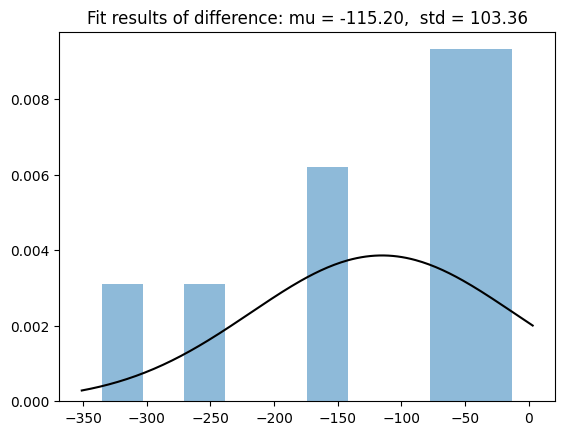

In [87]:
plot_hist(performance_ga - performance_aco, "difference")

In [79]:
alternative = "two-sided"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = scipy.stats.wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=0.000, p-value=0.002
Test Result:
p-value = 0.0020
H0 can be rejected on a level of significance of 0.05.


In [80]:
differences = performance_ga - performance_aco
# Calculate direction: Median and mean of the differences
mean_difference = np.mean(differences)
median_difference = np.median(differences)

print("Mean Difference:", mean_difference)
print("Median Difference:", median_difference)

Mean Difference: -115.2
Median Difference: -62.5


In [81]:
alternative = "greater"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = scipy.stats.wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=0.000, p-value=1.000
Test Result:
p-value = 1.0000
H0 cannot be rejected on a level of significance of 0.05.


In [82]:
alternative = "less"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = scipy.stats.wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=0.000, p-value=0.001
Test Result:
p-value = 0.0010
H0 can be rejected on a level of significance of 0.05.


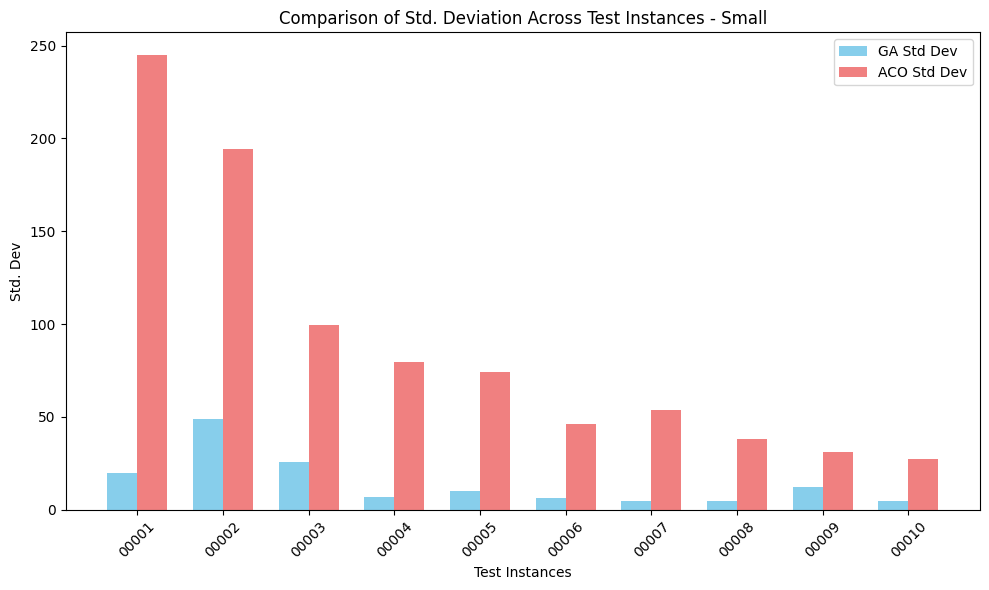

In [88]:
plot_variance_comparison(sol_ga, sol_aco, size = "Small")

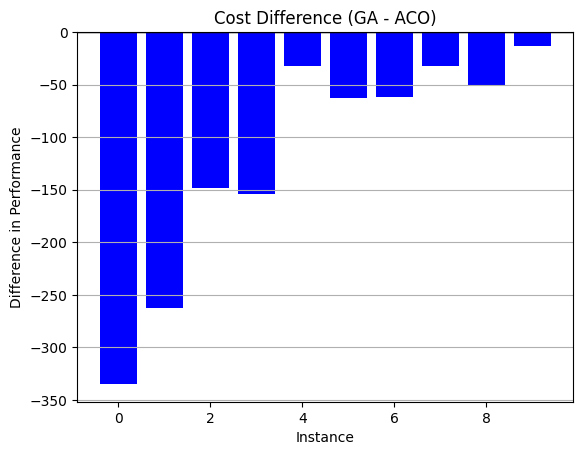

In [89]:
# Create indices for instances
indices = np.arange(len(performance_ga))

# Calculate differences
differences = np.array(performance_ga) - np.array(performance_aco)

# Bar chart
plt.bar(indices, differences, color=['blue' if d < 0 else 'orange' for d in differences])
plt.axhline(0, color='black', linewidth=1)
plt.title('Cost Difference (GA - ACO)')
plt.xlabel('Instance')
plt.ylabel('Difference in Performance')
plt.grid(axis='y')
plt.show()


### Medium

In [99]:
file_path = "/content/res_ga/medium.txt"
sol_ga = process_file(file_path, "medium")

file_path = "/content/res_aco/medium.txt"
sol_aco = process_file(file_path, "medium")

performance_ga = np.array([result[1] for result in sol_ga])
performance_aco = np.array([result[1] for result in sol_aco])

Instance: content/test/med/inst_200_20_00001 - Min Cost: 21993565.00 - Avg Cost: 22029296.00 - Std. Dev: 33541.40 - Time:12.112
Instance: content/test/med/inst_200_20_00002 - Min Cost: 7704776.00 - Avg Cost: 7747120.40 - Std. Dev: 25130.07 - Time:7.44
Instance: content/test/med/inst_200_20_00003 - Min Cost: 3898835.00 - Avg Cost: 3907547.80 - Std. Dev: 7123.79 - Time:5.408
Instance: content/test/med/inst_200_20_00004 - Min Cost: 2232350.00 - Avg Cost: 2242550.40 - Std. Dev: 8188.45 - Time:4.395999999999999
Instance: content/test/med/inst_200_20_00005 - Min Cost: 1402749.00 - Avg Cost: 1406925.40 - Std. Dev: 4482.49 - Time:3.696
Instance: content/test/med/inst_200_20_00006 - Min Cost: 1026378.00 - Avg Cost: 1035081.00 - Std. Dev: 5688.26 - Time:3.286
Instance: content/test/med/inst_200_20_00007 - Min Cost: 760471.00 - Avg Cost: 764310.20 - Std. Dev: 3395.72 - Time:2.946
Instance: content/test/med/inst_200_20_00008 - Min Cost: 578776.00 - Avg Cost: 584369.20 - Std. Dev: 3248.01 - Time:2.

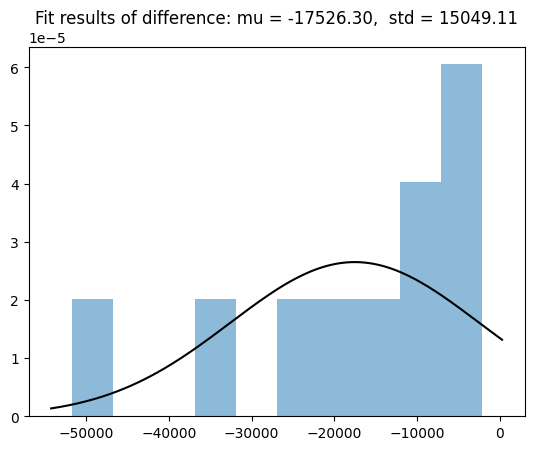

In [100]:
plot_hist(performance_ga - performance_aco, "difference")

In [101]:
alternative = "two-sided"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=0.000, p-value=0.002
Test Result:
p-value = 0.0020
H0 can be rejected on a level of significance of 0.05.


In [102]:
differences = performance_ga - performance_aco
# Calculate direction: Median and mean of the differences
mean_difference = np.mean(differences)
median_difference = np.median(differences)

print("Mean Difference:", mean_difference)
print("Median Difference:", median_difference)

Mean Difference: -17526.3
Median Difference: -11830.0


In [103]:
alternative = "greater"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = scipy.stats.wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=0.000, p-value=1.000
Test Result:
p-value = 1.0000
H0 cannot be rejected on a level of significance of 0.05.


In [104]:
alternative = "less"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = scipy.stats.wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=0.000, p-value=0.001
Test Result:
p-value = 0.0010
H0 can be rejected on a level of significance of 0.05.


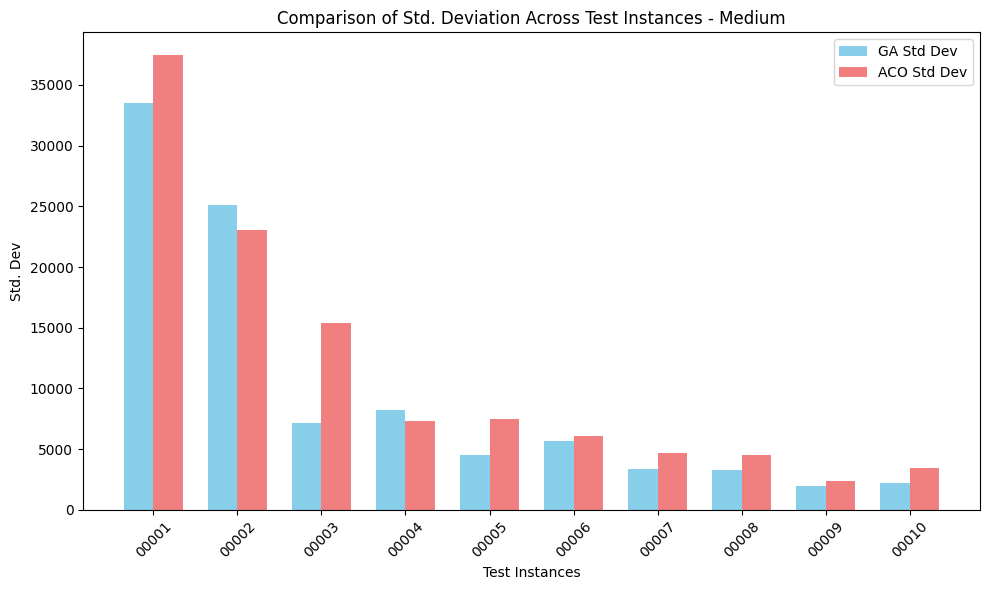

In [105]:
plot_variance_comparison(sol_ga, sol_aco, size = "Medium")

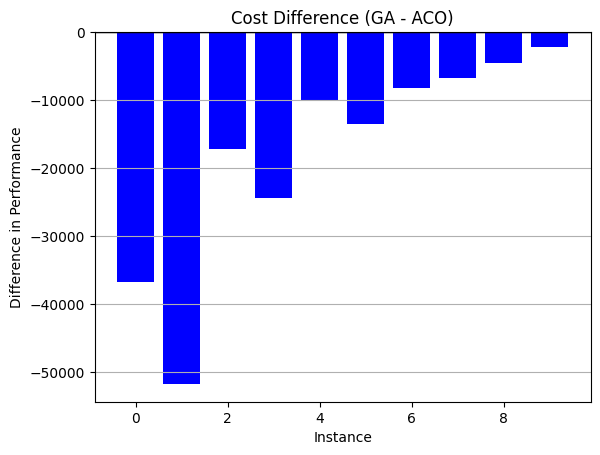

In [106]:
# Create indices for instances
indices = np.arange(len(performance_ga))

# Calculate differences
differences = np.array(performance_ga) - np.array(performance_aco)

# Bar chart
plt.bar(indices, differences, color=['blue' if d < 0 else 'orange' for d in differences])
plt.axhline(0, color='black', linewidth=1)
plt.title('Cost Difference (GA - ACO)')
plt.xlabel('Instance')
plt.ylabel('Difference in Performance')
plt.grid(axis='y')
plt.show()


### Medium-Large

In [ ]:
file_path = "/content/res_ga/medium_large.txt"
sol_ga = process_file(file_path, "medium_large")

file_path = "/content/res_aco/medium_large.txt"
sol_aco = process_file(file_path, "medium_large")

performance_ga = np.array([result[1] for result in sol_ga])
performance_aco = np.array([result[1] for result in sol_aco])

Instance: content/test/med_large/inst_500_40_00001 - Min Cost: 38071236.00 - Avg Cost: 38297539.60 - Std. Dev: 137107.80
Instance: content/test/med_large/inst_500_40_00004 - Min Cost: 88493670.00 - Avg Cost: 88734662.60 - Std. Dev: 226414.08
Instance: content/test/med_large/inst_500_40_00007 - Min Cost: 158395698.00 - Avg Cost: 158777172.40 - Std. Dev: 324726.40
Instance: content/test/med_large/inst_500_40_00010 - Min Cost: 236880558.00 - Avg Cost: 237583174.00 - Std. Dev: 402871.74
Instance: content/test/med_large/inst_500_40_00013 - Min Cost: 321715822.00 - Avg Cost: 321941965.20 - Std. Dev: 229663.23
Instance: content/test/med_large/inst_500_40_00016 - Min Cost: 420478963.00 - Avg Cost: 420995098.20 - Std. Dev: 460965.98
Instance: content/test/med_large/inst_500_40_00019 - Min Cost: 516534698.00 - Avg Cost: 516929247.60 - Std. Dev: 388049.22
Instance: content/test/med_large/inst_500_40_00001 - Min Cost: 38425062.00 - Avg Cost: 38549927.80 - Std. Dev: 72561.36
Instance: content/test/

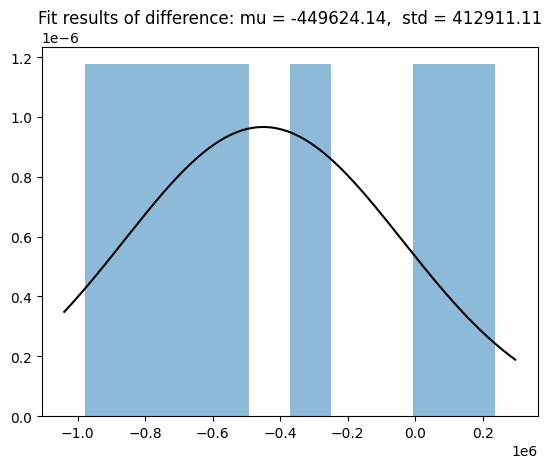

In [ ]:
plot_hist(performance_ga - performance_aco, "difference")

In [ ]:
alternative = "two-sided"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=3.000, p-value=0.078
Test Result:
p-value = 0.0781
H0 cannot be rejected on a level of significance of 0.05.


In [ ]:
alternative = "two-sided"
alpha = 0.1

# Wilcoxon signed-rank test
stat, p_value = wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=3.000, p-value=0.078
Test Result:
p-value = 0.0781
H0 can be rejected on a level of significance of 0.1.


In [ ]:
differences = performance_ga - performance_aco
# Calculate direction: Median and mean of the differences
mean_difference = np.mean(differences)
median_difference = np.median(differences)

print("Mean Difference:", mean_difference)
print("Median Difference:", median_difference)

Mean Difference: -449624.14285714284
Median Difference: -533586.0


In [ ]:
alternative = "greater"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = scipy.stats.wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=3.000, p-value=0.977
Test Result:
p-value = 0.9766
H0 cannot be rejected on a level of significance of 0.05.


In [ ]:
alternative = "less"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = scipy.stats.wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=3.000, p-value=0.039
Test Result:
p-value = 0.0391
H0 can be rejected on a level of significance of 0.05.


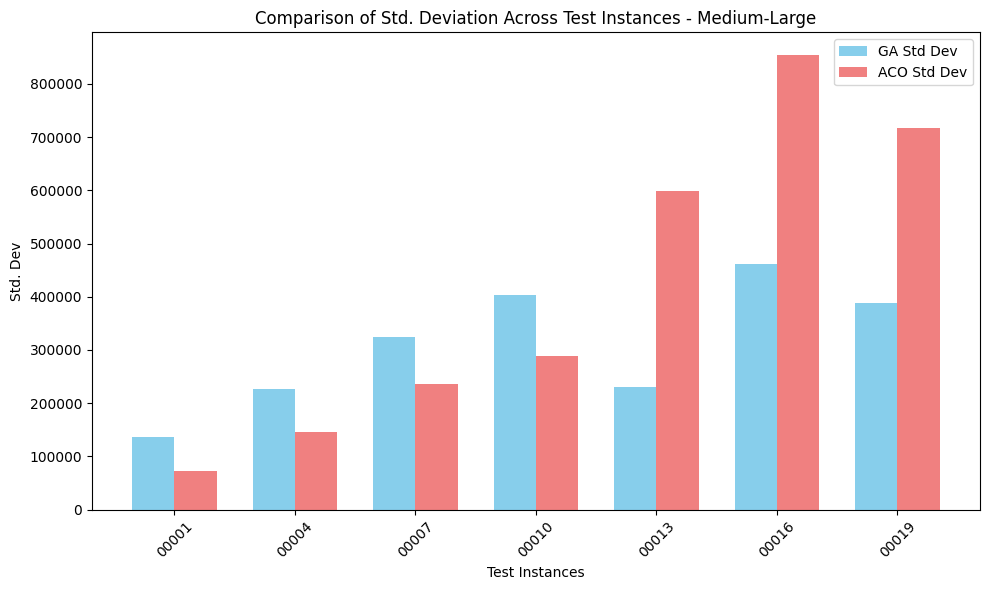

In [ ]:
plot_variance_comparison(sol_ga, sol_aco, size = "Medium-Large")

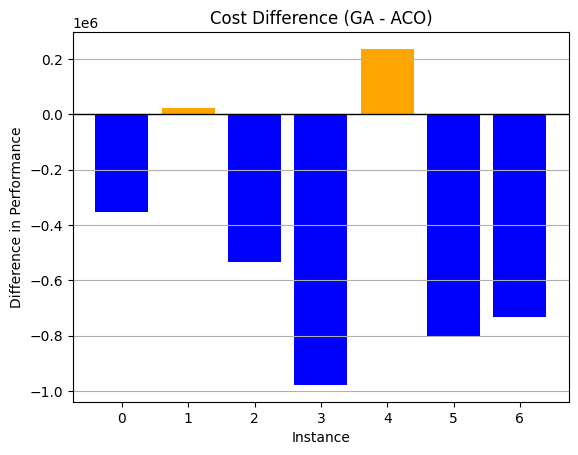

In [ ]:
# Create indices for instances
indices = np.arange(len(performance_ga))

# Calculate differences
differences = np.array(performance_ga) - np.array(performance_aco)

# Bar chart
plt.bar(indices, differences, color=['blue' if d < 0 else 'orange' for d in differences])
plt.axhline(0, color='black', linewidth=1)
plt.title('Cost Difference (GA - ACO)')
plt.xlabel('Instance')
plt.ylabel('Difference in Performance')
plt.grid(axis='y')
plt.show()


### Large

In [ ]:
file_path = "/content/res_ga/large.txt"
sol_ga = process_file(file_path, "large")

file_path = "/content/res_aco/large.txt"
sol_aco = process_file(file_path, "large")

performance_ga = np.array([result[1] for result in sol_ga])
performance_aco = np.array([result[1] for result in sol_aco])

Instance: content/test/large/inst_1000_60_00001 - Min Cost: 14932274808.00 - Avg Cost: 14940999432.80 - Std. Dev: 7357125.34
Instance: content/test/large/inst_1000_60_00002 - Min Cost: 5237006884.00 - Avg Cost: 5240647169.60 - Std. Dev: 3089238.81
Instance: content/test/large/inst_1000_60_00003 - Min Cost: 2635439581.00 - Avg Cost: 2638299603.00 - Std. Dev: 2365392.52
Instance: content/test/large/inst_1000_60_00004 - Min Cost: 1567803702.00 - Avg Cost: 1570023131.40 - Std. Dev: 2031316.78
Instance: content/test/large/inst_1000_60_00005 - Min Cost: 1029816197.00 - Avg Cost: 1032566067.00 - Std. Dev: 1721904.19
Instance: content/test/large/inst_1000_60_00006 - Min Cost: 741743231.00 - Avg Cost: 743305842.60 - Std. Dev: 1086723.04
Instance: content/test/large/inst_1000_60_00007 - Min Cost: 543493785.00 - Avg Cost: 544783865.00 - Std. Dev: 1146068.40
Instance: content/test/large/inst_1000_60_00008 - Min Cost: 427098622.00 - Avg Cost: 428572345.00 - Std. Dev: 1394135.51
Instance: content/te

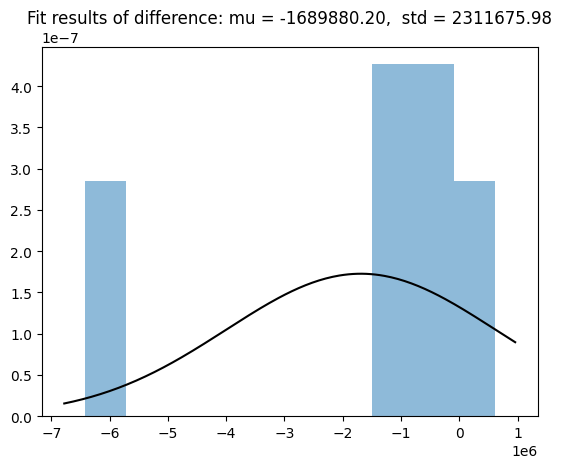

In [ ]:
plot_hist(performance_ga - performance_aco, "difference")

In [ ]:
# Paired
alternative = "two-sided"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=5.000, p-value=0.020
Test Result:
p-value = 0.0195
H0 can be rejected on a level of significance of 0.05.


In [ ]:
differences = performance_ga - performance_aco
# Calculate direction: Median and mean of the differences
mean_difference = np.mean(differences)
median_difference = np.median(differences)

print("Mean Difference:", mean_difference)
print("Median Difference:", median_difference)

Mean Difference: -1689880.2
Median Difference: -859409.0


In [ ]:
alternative = "greater"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=5.000, p-value=0.993
Test Result:
p-value = 0.9932
H0 cannot be rejected on a level of significance of 0.05.


In [ ]:
alternative = "less"
alpha = 0.05

# Wilcoxon signed-rank test
stat, p_value = wilcoxon(performance_ga, performance_aco, alternative=alternative)
print(f"Wilcoxon test: stat={stat:.3f}, p-value={p_value:.3f}")

# Print results
print_decision(p_value, alpha)

Wilcoxon test: stat=5.000, p-value=0.010
Test Result:
p-value = 0.0098
H0 can be rejected on a level of significance of 0.05.


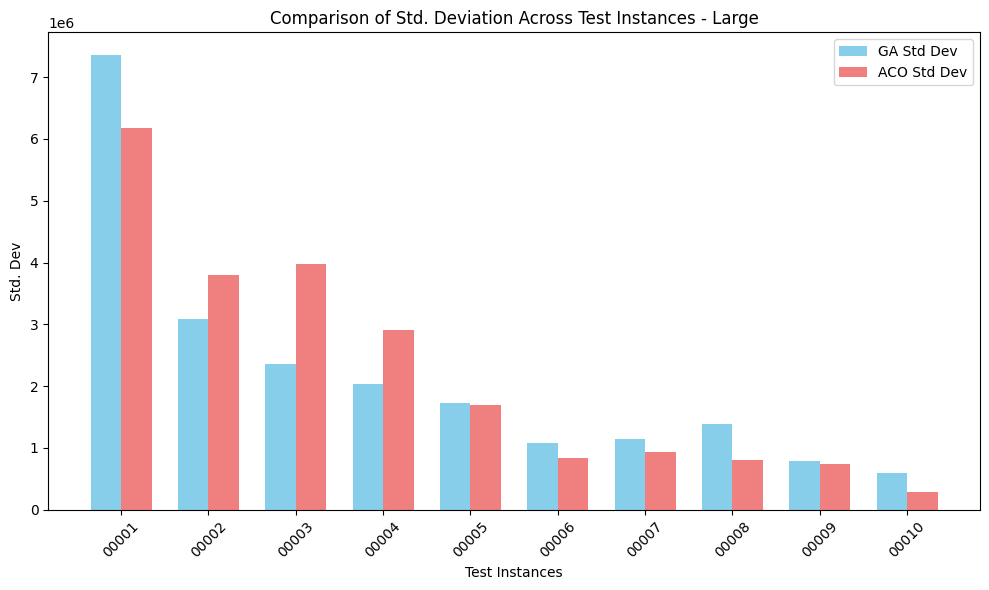

In [ ]:
plot_variance_comparison(sol_ga, sol_aco, size = "Large")

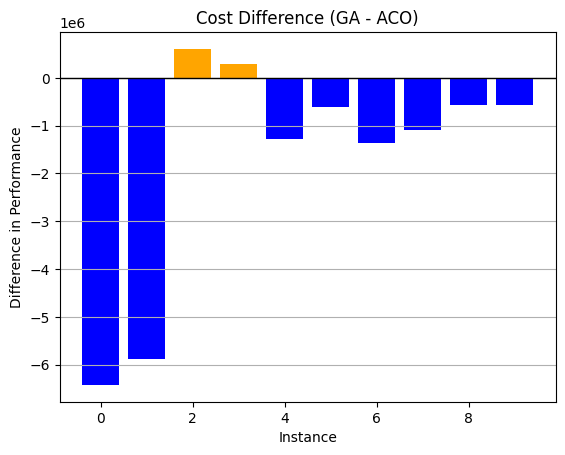

In [ ]:
# Create indices for instances
indices = np.arange(len(performance_ga))

# Calculate differences
differences = np.array(performance_ga) - np.array(performance_aco)

# Bar chart
plt.bar(indices, differences, color=['blue' if d < 0 else 'orange' for d in differences])
plt.axhline(0, color='black', linewidth=1)
plt.title('Cost Difference (GA - ACO)')
plt.xlabel('Instance')
plt.ylabel('Difference in Performance')
plt.grid(axis='y')
plt.show()


# Task 4

### Convergence analysis

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

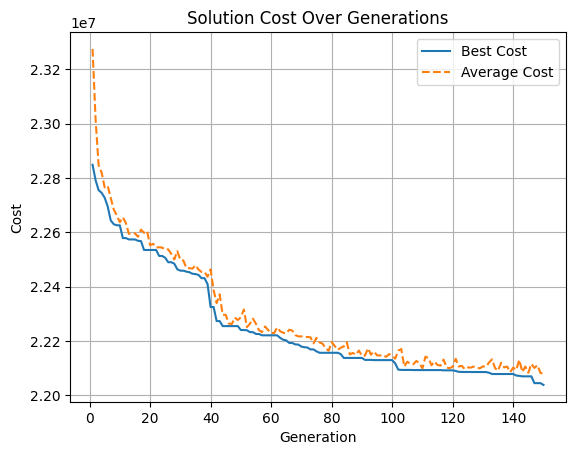

Minimum weighted crossing cost: 22038457.0


In [ ]:
graph = load_instance(items_test_med[0])

params = GAParameters(population_size=40, generations=150, elite_size=13, tournament_size=25, mutation_rate=0.255, crossover_rate=0.79, constraint_penalty=213178)
# Solve the problem
solution, cost = solve_mwccp(graph, params)
print(f"Minimum weighted crossing cost: {cost}")

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

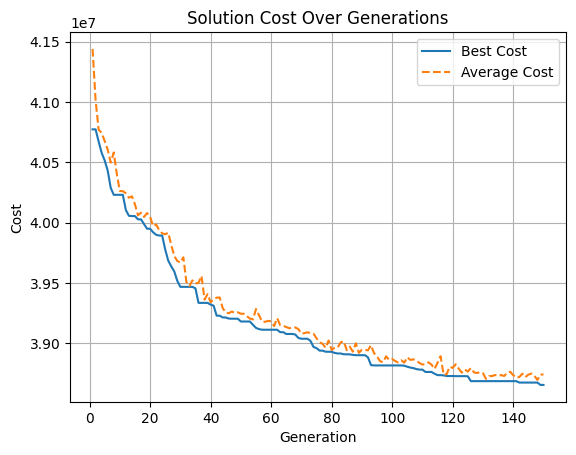

Minimum weighted crossing cost: 38655186.0


In [ ]:
graph = load_instance(items_test_med_large[0])

params = GAParameters(population_size=40, generations=150, elite_size=13, tournament_size=25, mutation_rate=0.255, crossover_rate=0.79, constraint_penalty=213178)
# Solve the problem
solution, cost = solve_mwccp(graph, params)
print(f"Minimum weighted crossing cost: {cost}")

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

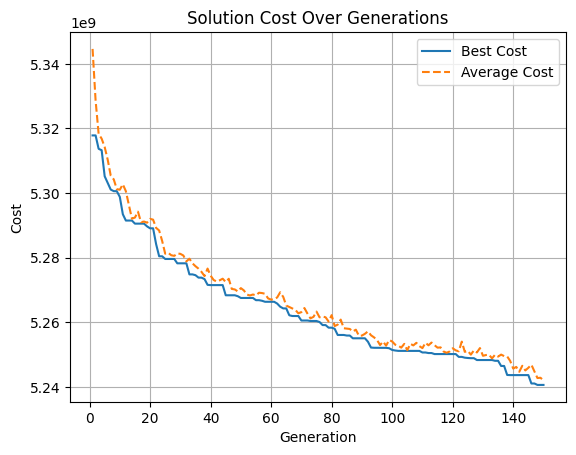

Minimum weighted crossing cost: 5240583061.0


In [ ]:
graph = load_instance(items_test_large[0])

params = GAParameters(population_size=40, generations=150, elite_size=13, tournament_size=25, mutation_rate=0.255, crossover_rate=0.79, constraint_penalty=213178)
# Solve the problem
solution, cost = solve_mwccp(graph, params)
print(f"Minimum weighted crossing cost: {cost}")

### Scalability Testing

In [ ]:
graph_sizes = list_files_in_folder('/content/data')
instance_sizes = sorted(
    graph_sizes,
    key=lambda x: int(x.split('_')[1])  # Extract and convert the number after "inst_"
)

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

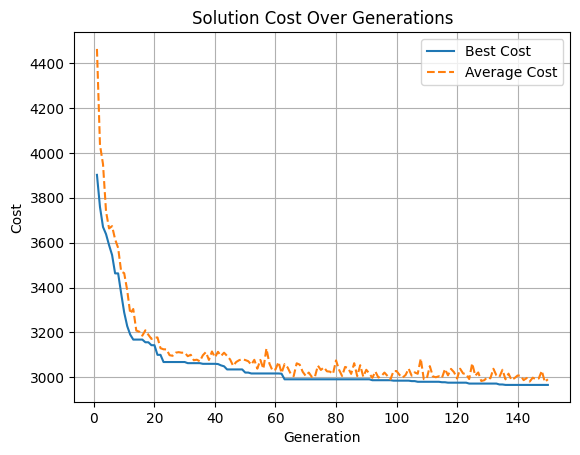

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

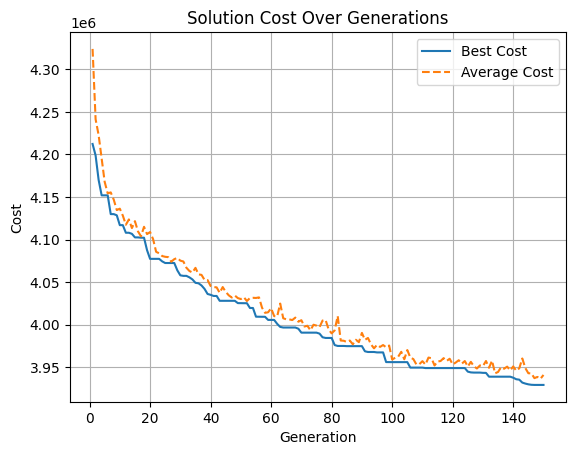

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

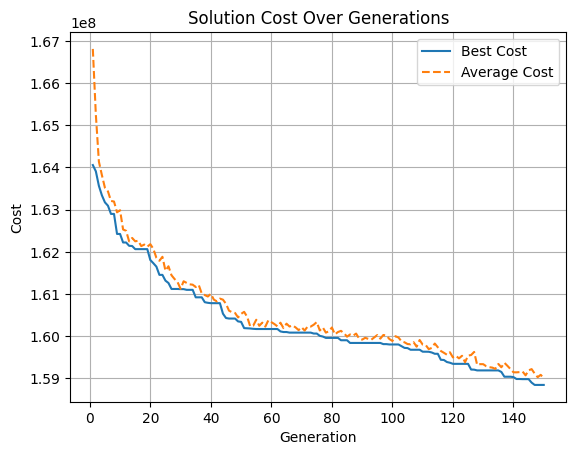

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

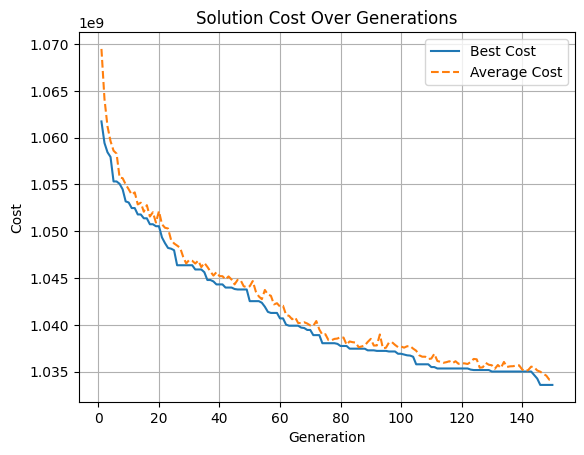

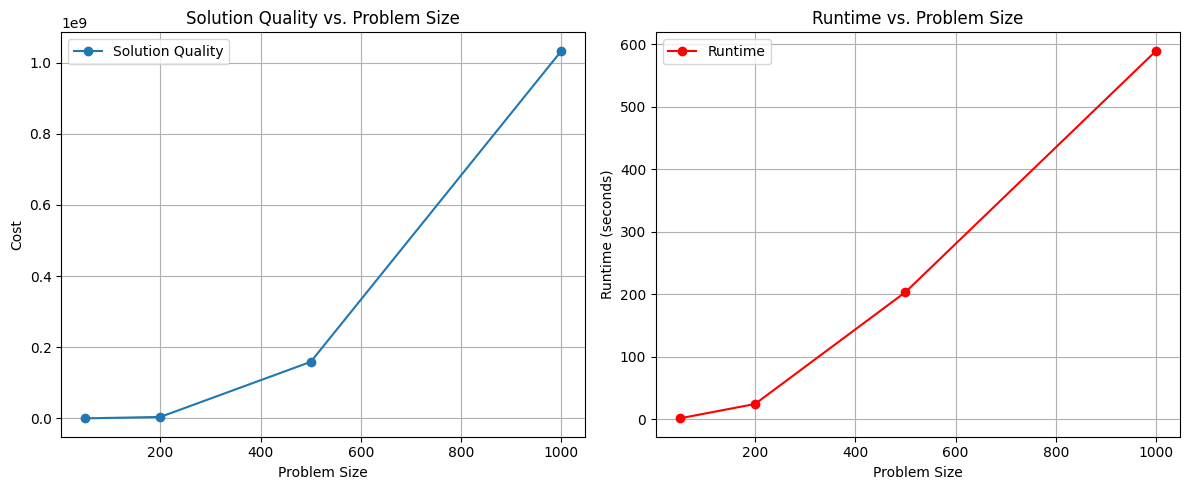

In [ ]:
params = GAParameters(population_size=40, generations=150, elite_size=13, tournament_size=25, mutation_rate=0.255, crossover_rate=0.79, constraint_penalty=213178)

results = []

for size in instance_sizes:
    graph = load_instance(size)
    start_time = time.time()
    solution, cost = solve_mwccp(graph, params)
    runtime = time.time() - start_time
    results.append((size, cost, runtime))

# Visualize results

sizes, costs, runtimes = zip(*results)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([50, 200, 500, 1000], costs, marker='o', label='Solution Quality')
plt.xlabel('Problem Size')
plt.ylabel('Cost')
plt.title('Solution Quality vs. Problem Size')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([50, 200, 500, 1000], runtimes, marker='o', color='red', label='Runtime')
plt.xlabel('Problem Size')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Problem Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Runtime vs. Solution Quality Trade-off

In [ ]:
graph_sizes

['/content/data/inst_200_20_00003',
 '/content/data/inst_1000_60_00005',
 '/content/data/inst_500_40_00007',
 '/content/data/inst_50_4_00006']

Generation 1/5
Generation 2/5
Generation 3/5
Generation 4/5
Generation 5/5


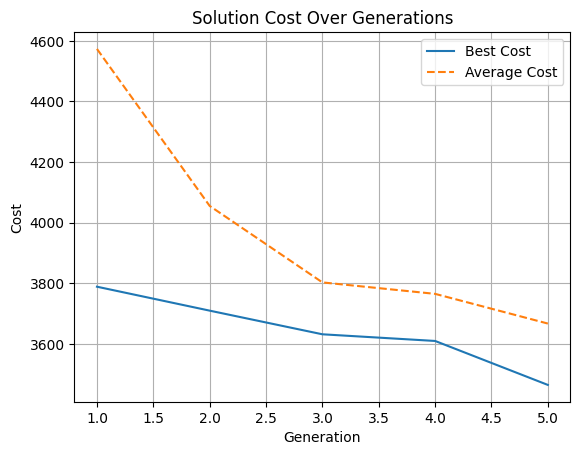

Generation 1/10
Generation 2/10
Generation 3/10
Generation 4/10
Generation 5/10
Generation 6/10
Generation 7/10
Generation 8/10
Generation 9/10
Generation 10/10


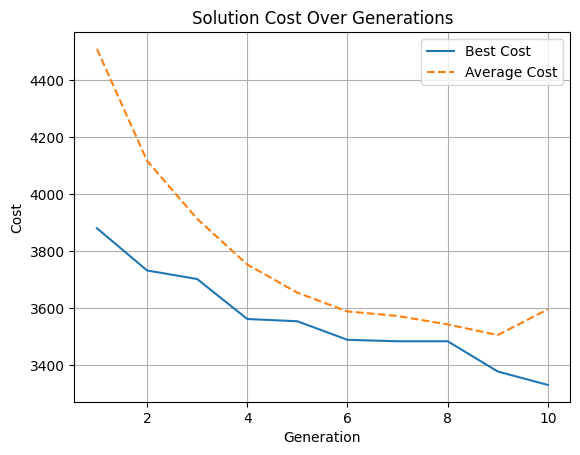

Generation 1/50
Generation 2/50
Generation 3/50
Generation 4/50
Generation 5/50
Generation 6/50
Generation 7/50
Generation 8/50
Generation 9/50
Generation 10/50
Generation 11/50
Generation 12/50
Generation 13/50
Generation 14/50
Generation 15/50
Generation 16/50
Generation 17/50
Generation 18/50
Generation 19/50
Generation 20/50
Generation 21/50
Generation 22/50
Generation 23/50
Generation 24/50
Generation 25/50
Generation 26/50
Generation 27/50
Generation 28/50
Generation 29/50
Generation 30/50
Generation 31/50
Generation 32/50
Generation 33/50
Generation 34/50
Generation 35/50
Generation 36/50
Generation 37/50
Generation 38/50
Generation 39/50
Generation 40/50
Generation 41/50
Generation 42/50
Generation 43/50
Generation 44/50
Generation 45/50
Generation 46/50
Generation 47/50
Generation 48/50
Generation 49/50
Generation 50/50


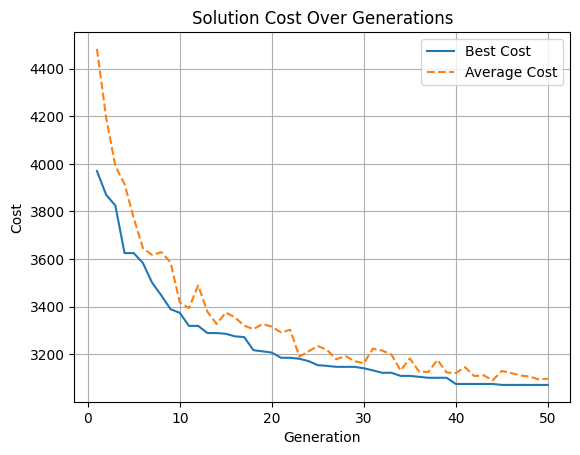

Generation 1/100
Generation 2/100
Generation 3/100
Generation 4/100
Generation 5/100
Generation 6/100
Generation 7/100
Generation 8/100
Generation 9/100
Generation 10/100
Generation 11/100
Generation 12/100
Generation 13/100
Generation 14/100
Generation 15/100
Generation 16/100
Generation 17/100
Generation 18/100
Generation 19/100
Generation 20/100
Generation 21/100
Generation 22/100
Generation 23/100
Generation 24/100
Generation 25/100
Generation 26/100
Generation 27/100
Generation 28/100
Generation 29/100
Generation 30/100
Generation 31/100
Generation 32/100
Generation 33/100
Generation 34/100
Generation 35/100
Generation 36/100
Generation 37/100
Generation 38/100
Generation 39/100
Generation 40/100
Generation 41/100
Generation 42/100
Generation 43/100
Generation 44/100
Generation 45/100
Generation 46/100
Generation 47/100
Generation 48/100
Generation 49/100
Generation 50/100
Generation 51/100
Generation 52/100
Generation 53/100
Generation 54/100
Generation 55/100
Generation 56/100
G

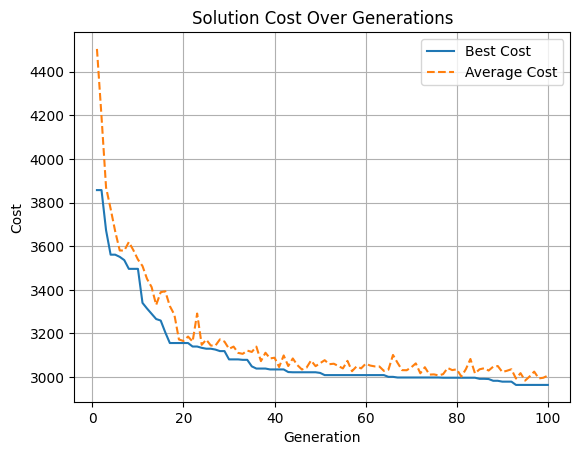

Generation 1/200
Generation 2/200
Generation 3/200
Generation 4/200
Generation 5/200
Generation 6/200
Generation 7/200
Generation 8/200
Generation 9/200
Generation 10/200
Generation 11/200
Generation 12/200
Generation 13/200
Generation 14/200
Generation 15/200
Generation 16/200
Generation 17/200
Generation 18/200
Generation 19/200
Generation 20/200
Generation 21/200
Generation 22/200
Generation 23/200
Generation 24/200
Generation 25/200
Generation 26/200
Generation 27/200
Generation 28/200
Generation 29/200
Generation 30/200
Generation 31/200
Generation 32/200
Generation 33/200
Generation 34/200
Generation 35/200
Generation 36/200
Generation 37/200
Generation 38/200
Generation 39/200
Generation 40/200
Generation 41/200
Generation 42/200
Generation 43/200
Generation 44/200
Generation 45/200
Generation 46/200
Generation 47/200
Generation 48/200
Generation 49/200
Generation 50/200
Generation 51/200
Generation 52/200
Generation 53/200
Generation 54/200
Generation 55/200
Generation 56/200
G

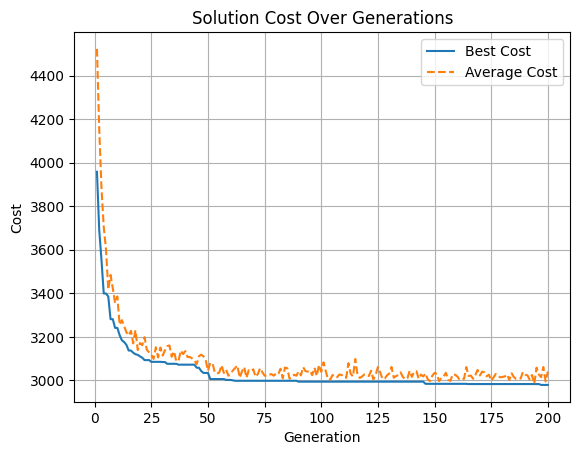

Generation 1/400
Generation 2/400
Generation 3/400
Generation 4/400
Generation 5/400
Generation 6/400
Generation 7/400
Generation 8/400
Generation 9/400
Generation 10/400
Generation 11/400
Generation 12/400
Generation 13/400
Generation 14/400
Generation 15/400
Generation 16/400
Generation 17/400
Generation 18/400
Generation 19/400
Generation 20/400
Generation 21/400
Generation 22/400
Generation 23/400
Generation 24/400
Generation 25/400
Generation 26/400
Generation 27/400
Generation 28/400
Generation 29/400
Generation 30/400
Generation 31/400
Generation 32/400
Generation 33/400
Generation 34/400
Generation 35/400
Generation 36/400
Generation 37/400
Generation 38/400
Generation 39/400
Generation 40/400
Generation 41/400
Generation 42/400
Generation 43/400
Generation 44/400
Generation 45/400
Generation 46/400
Generation 47/400
Generation 48/400
Generation 49/400
Generation 50/400
Generation 51/400
Generation 52/400
Generation 53/400
Generation 54/400
Generation 55/400
Generation 56/400
G

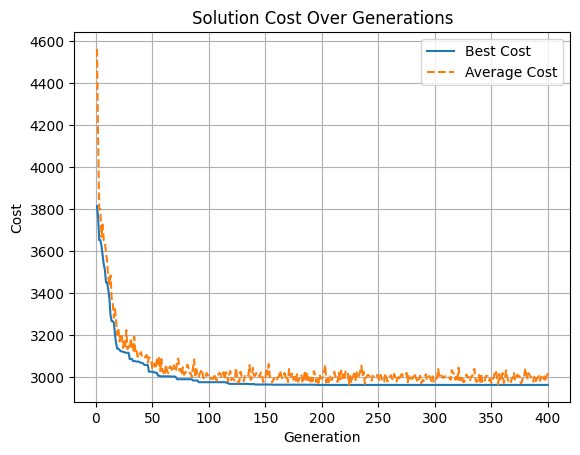

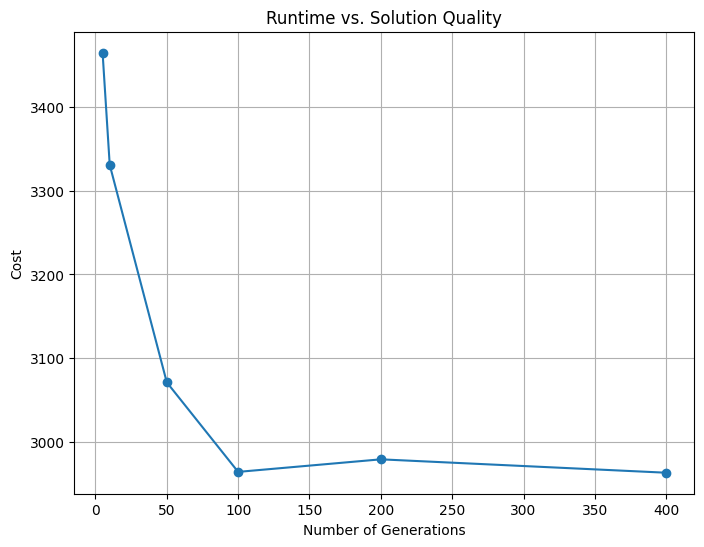

In [ ]:
graph = load_instance(graph_sizes[2])
generation_limits = [5, 10, 50, 100, 200, 400]
results = []

for generations in generation_limits:
    params.generations = generations
    solution, cost = solve_mwccp(graph, params)
    results.append((generations, cost))

# Plot Results
gen_limits, costs = zip(*results)
plt.figure(figsize=(8, 6))
plt.plot(gen_limits, costs, marker='o')
plt.title("Runtime vs. Solution Quality")
plt.xlabel("Number of Generations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


Generation 1/5
Generation 2/5
Generation 3/5
Generation 4/5
Generation 5/5


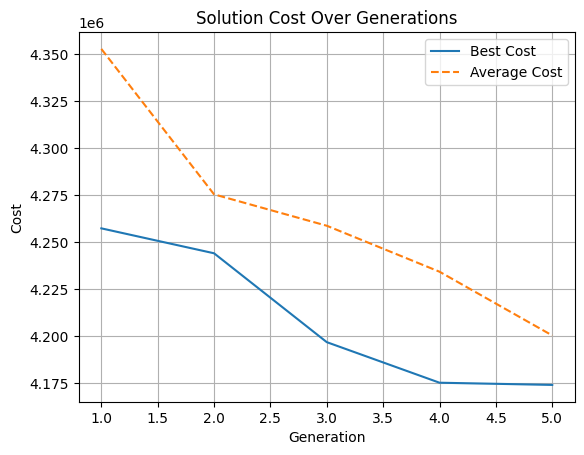

Generation 1/10
Generation 2/10
Generation 3/10
Generation 4/10
Generation 5/10
Generation 6/10
Generation 7/10
Generation 8/10
Generation 9/10
Generation 10/10


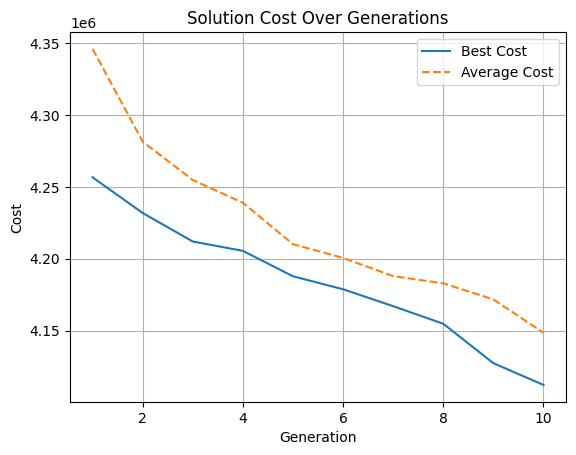

Generation 1/50
Generation 2/50
Generation 3/50
Generation 4/50
Generation 5/50
Generation 6/50
Generation 7/50
Generation 8/50
Generation 9/50
Generation 10/50
Generation 11/50
Generation 12/50
Generation 13/50
Generation 14/50
Generation 15/50
Generation 16/50
Generation 17/50
Generation 18/50
Generation 19/50
Generation 20/50
Generation 21/50
Generation 22/50
Generation 23/50
Generation 24/50
Generation 25/50
Generation 26/50
Generation 27/50
Generation 28/50
Generation 29/50
Generation 30/50
Generation 31/50
Generation 32/50
Generation 33/50
Generation 34/50
Generation 35/50
Generation 36/50
Generation 37/50
Generation 38/50
Generation 39/50
Generation 40/50
Generation 41/50
Generation 42/50
Generation 43/50
Generation 44/50
Generation 45/50
Generation 46/50
Generation 47/50
Generation 48/50
Generation 49/50
Generation 50/50


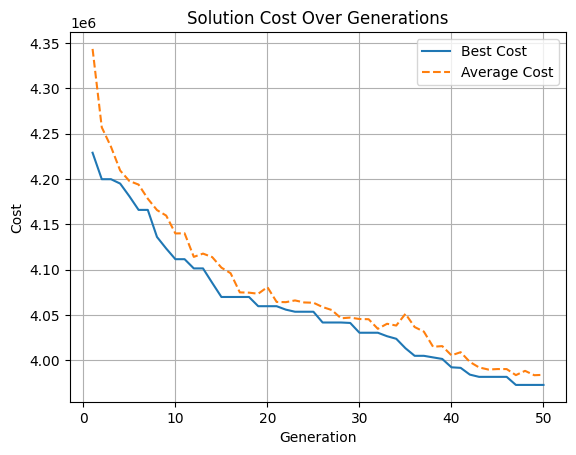

Generation 1/100
Generation 2/100
Generation 3/100
Generation 4/100
Generation 5/100
Generation 6/100
Generation 7/100
Generation 8/100
Generation 9/100
Generation 10/100
Generation 11/100
Generation 12/100
Generation 13/100
Generation 14/100
Generation 15/100
Generation 16/100
Generation 17/100
Generation 18/100
Generation 19/100
Generation 20/100
Generation 21/100
Generation 22/100
Generation 23/100
Generation 24/100
Generation 25/100
Generation 26/100
Generation 27/100
Generation 28/100
Generation 29/100
Generation 30/100
Generation 31/100
Generation 32/100
Generation 33/100
Generation 34/100
Generation 35/100
Generation 36/100
Generation 37/100
Generation 38/100
Generation 39/100
Generation 40/100
Generation 41/100
Generation 42/100
Generation 43/100
Generation 44/100
Generation 45/100
Generation 46/100
Generation 47/100
Generation 48/100
Generation 49/100
Generation 50/100
Generation 51/100
Generation 52/100
Generation 53/100
Generation 54/100
Generation 55/100
Generation 56/100
G

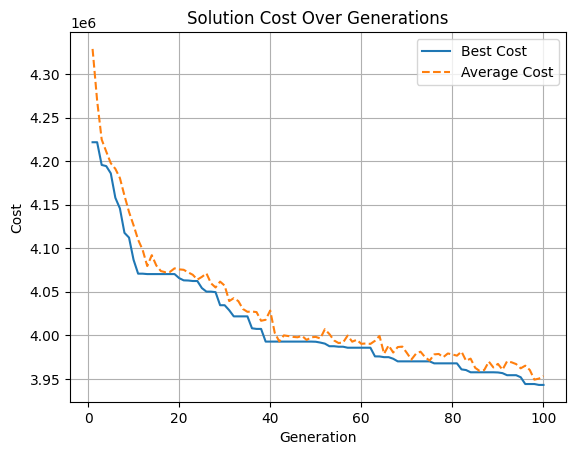

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

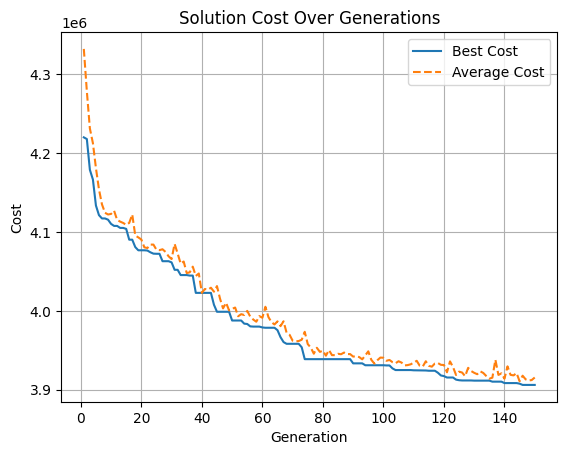

Generation 1/300
Generation 2/300
Generation 3/300
Generation 4/300
Generation 5/300
Generation 6/300
Generation 7/300
Generation 8/300
Generation 9/300
Generation 10/300
Generation 11/300
Generation 12/300
Generation 13/300
Generation 14/300
Generation 15/300
Generation 16/300
Generation 17/300
Generation 18/300
Generation 19/300
Generation 20/300
Generation 21/300
Generation 22/300
Generation 23/300
Generation 24/300
Generation 25/300
Generation 26/300
Generation 27/300
Generation 28/300
Generation 29/300
Generation 30/300
Generation 31/300
Generation 32/300
Generation 33/300
Generation 34/300
Generation 35/300
Generation 36/300
Generation 37/300
Generation 38/300
Generation 39/300
Generation 40/300
Generation 41/300
Generation 42/300
Generation 43/300
Generation 44/300
Generation 45/300
Generation 46/300
Generation 47/300
Generation 48/300
Generation 49/300
Generation 50/300
Generation 51/300
Generation 52/300
Generation 53/300
Generation 54/300
Generation 55/300
Generation 56/300
G

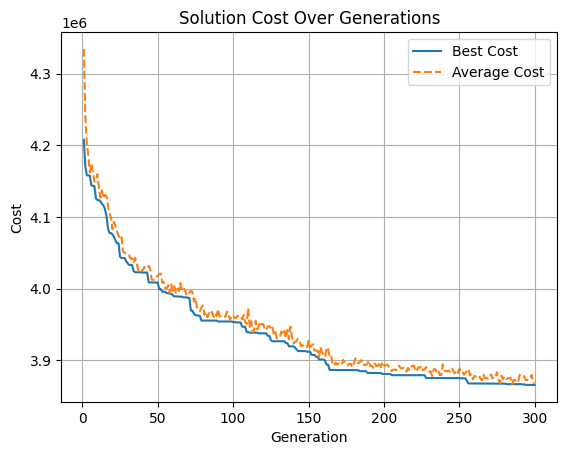

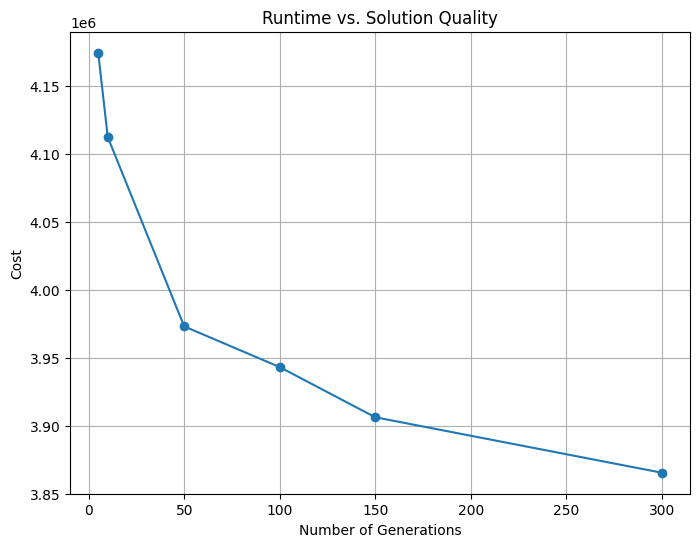

In [ ]:
graph = load_instance(graph_sizes[0])
generation_limits = [5, 10, 50, 100, 150, 300]
results = []

for generations in generation_limits:
    params.generations = generations
    solution, cost = solve_mwccp(graph, params)
    results.append((generations, cost))

# Plot Results
gen_limits, costs = zip(*results)
plt.figure(figsize=(8, 6))
plt.plot(gen_limits, costs, marker='o')
plt.title("Runtime vs. Solution Quality")
plt.xlabel("Number of Generations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


Generation 1/5
Generation 2/5
Generation 3/5
Generation 4/5
Generation 5/5


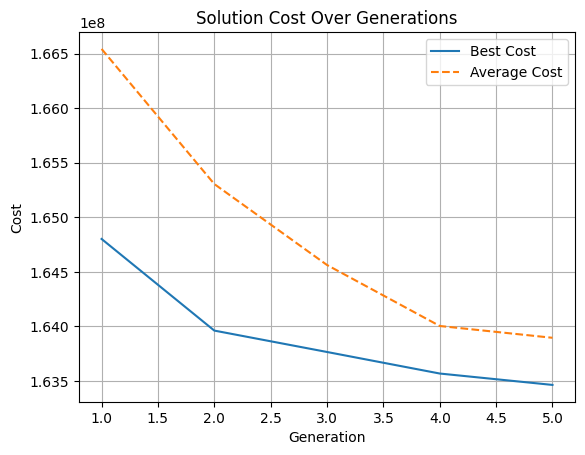

Generation 1/10
Generation 2/10
Generation 3/10
Generation 4/10
Generation 5/10
Generation 6/10
Generation 7/10
Generation 8/10
Generation 9/10
Generation 10/10


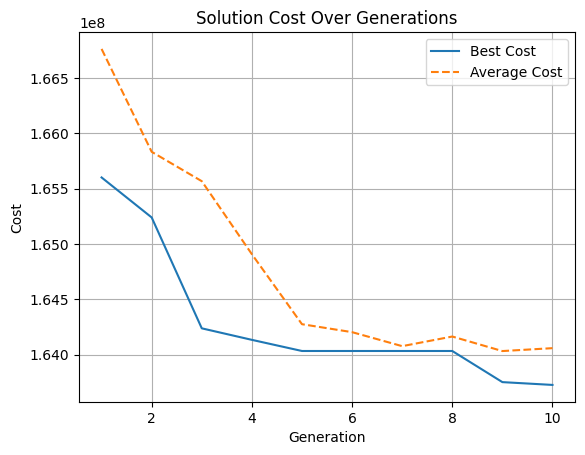

Generation 1/50
Generation 2/50
Generation 3/50
Generation 4/50
Generation 5/50
Generation 6/50
Generation 7/50
Generation 8/50
Generation 9/50
Generation 10/50
Generation 11/50
Generation 12/50
Generation 13/50
Generation 14/50
Generation 15/50
Generation 16/50
Generation 17/50
Generation 18/50
Generation 19/50
Generation 20/50
Generation 21/50
Generation 22/50
Generation 23/50
Generation 24/50
Generation 25/50
Generation 26/50
Generation 27/50
Generation 28/50
Generation 29/50
Generation 30/50
Generation 31/50
Generation 32/50
Generation 33/50
Generation 34/50
Generation 35/50
Generation 36/50
Generation 37/50
Generation 38/50
Generation 39/50
Generation 40/50
Generation 41/50
Generation 42/50
Generation 43/50
Generation 44/50
Generation 45/50
Generation 46/50
Generation 47/50
Generation 48/50
Generation 49/50
Generation 50/50


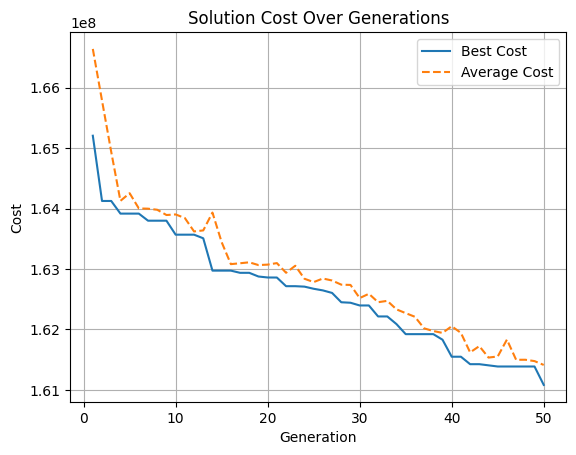

Generation 1/100
Generation 2/100
Generation 3/100
Generation 4/100
Generation 5/100
Generation 6/100
Generation 7/100
Generation 8/100
Generation 9/100
Generation 10/100
Generation 11/100
Generation 12/100
Generation 13/100
Generation 14/100
Generation 15/100
Generation 16/100
Generation 17/100
Generation 18/100
Generation 19/100
Generation 20/100
Generation 21/100
Generation 22/100
Generation 23/100
Generation 24/100
Generation 25/100
Generation 26/100
Generation 27/100
Generation 28/100
Generation 29/100
Generation 30/100
Generation 31/100
Generation 32/100
Generation 33/100
Generation 34/100
Generation 35/100
Generation 36/100
Generation 37/100
Generation 38/100
Generation 39/100
Generation 40/100
Generation 41/100
Generation 42/100
Generation 43/100
Generation 44/100
Generation 45/100
Generation 46/100
Generation 47/100
Generation 48/100
Generation 49/100
Generation 50/100
Generation 51/100
Generation 52/100
Generation 53/100
Generation 54/100
Generation 55/100
Generation 56/100
G

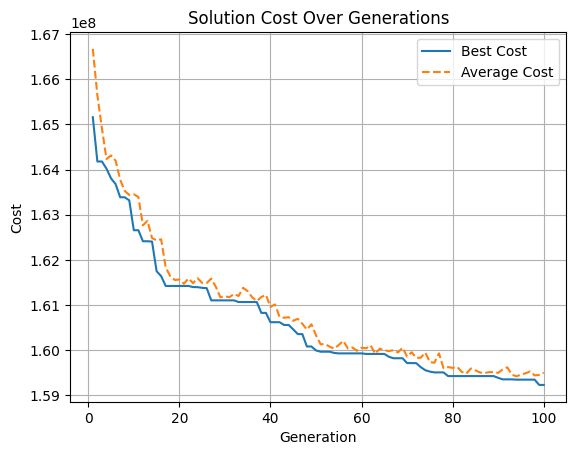

Generation 1/150
Generation 2/150
Generation 3/150
Generation 4/150
Generation 5/150
Generation 6/150
Generation 7/150
Generation 8/150
Generation 9/150
Generation 10/150
Generation 11/150
Generation 12/150
Generation 13/150
Generation 14/150
Generation 15/150
Generation 16/150
Generation 17/150
Generation 18/150
Generation 19/150
Generation 20/150
Generation 21/150
Generation 22/150
Generation 23/150
Generation 24/150
Generation 25/150
Generation 26/150
Generation 27/150
Generation 28/150
Generation 29/150
Generation 30/150
Generation 31/150
Generation 32/150
Generation 33/150
Generation 34/150
Generation 35/150
Generation 36/150
Generation 37/150
Generation 38/150
Generation 39/150
Generation 40/150
Generation 41/150
Generation 42/150
Generation 43/150
Generation 44/150
Generation 45/150
Generation 46/150
Generation 47/150
Generation 48/150
Generation 49/150
Generation 50/150
Generation 51/150
Generation 52/150
Generation 53/150
Generation 54/150
Generation 55/150
Generation 56/150
G

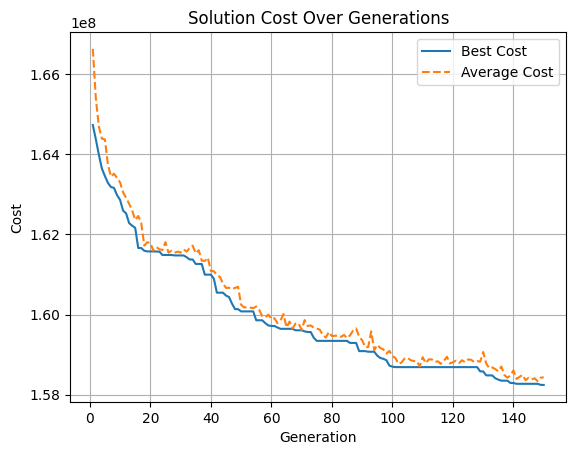

Generation 1/300
Generation 2/300
Generation 3/300
Generation 4/300
Generation 5/300
Generation 6/300
Generation 7/300
Generation 8/300
Generation 9/300
Generation 10/300
Generation 11/300
Generation 12/300
Generation 13/300
Generation 14/300
Generation 15/300
Generation 16/300
Generation 17/300
Generation 18/300
Generation 19/300
Generation 20/300
Generation 21/300
Generation 22/300
Generation 23/300
Generation 24/300
Generation 25/300
Generation 26/300
Generation 27/300
Generation 28/300
Generation 29/300
Generation 30/300
Generation 31/300
Generation 32/300
Generation 33/300
Generation 34/300
Generation 35/300
Generation 36/300
Generation 37/300
Generation 38/300
Generation 39/300
Generation 40/300
Generation 41/300
Generation 42/300
Generation 43/300
Generation 44/300
Generation 45/300
Generation 46/300
Generation 47/300
Generation 48/300
Generation 49/300
Generation 50/300
Generation 51/300
Generation 52/300
Generation 53/300
Generation 54/300
Generation 55/300
Generation 56/300
G

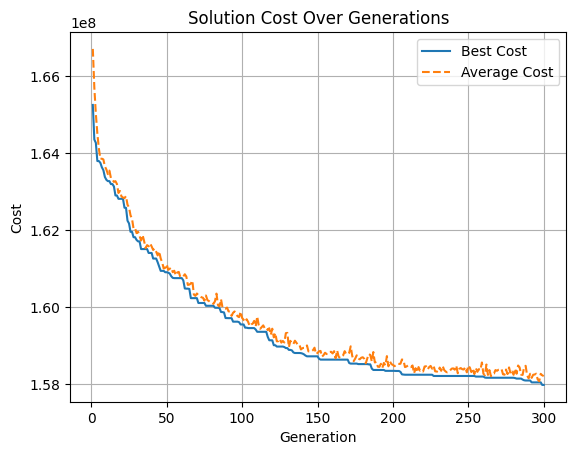

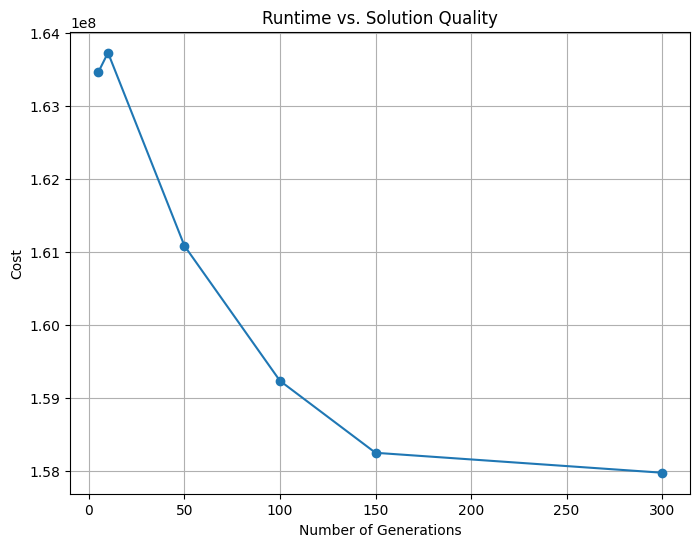

In [ ]:
graph = load_instance(graph_sizes[-2])
generation_limits = [5, 10, 50, 100, 150, 300]
results = []

for generations in generation_limits:
    params.generations = generations
    solution, cost = solve_mwccp(graph, params)
    results.append((generations, cost))

# Plot Results
gen_limits, costs = zip(*results)
plt.figure(figsize=(8, 6))
plt.plot(gen_limits, costs, marker='o')
plt.title("Runtime vs. Solution Quality")
plt.xlabel("Number of Generations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


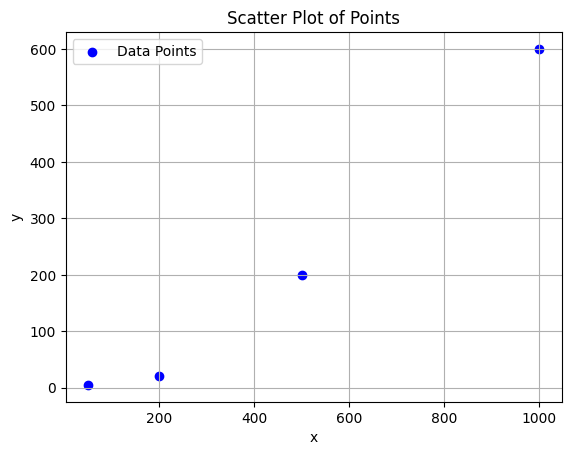

In [ ]:
import matplotlib.pyplot as plt

# Points
x = [50, 200, 500, 1000]
y = [5, 20, 200, 600]

# Plot
plt.scatter(x, y, label="Data Points", color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter Plot of Points")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

# Fit a linear model
coefficients = np.polyfit(x, y, 1)  # Degree 1 for linear
linear_model = np.poly1d(coefficients)

# Predicted values
y_pred_linear = linear_model(x)

print("Linear coefficients:", coefficients)
# Fit a quadratic model
coefficients_quad = np.polyfit(x, y, 2)  # Degree 2 for quadratic
quadratic_model = np.poly1d(coefficients_quad)

# Predicted values
y_pred_quad = quadratic_model(x)

print("Quadratic coefficients:", coefficients_quad)
from scipy.optimize import curve_fit

def exponential_model(x, a, b):
    return a * np.exp(b * x)

# Fit the model
params, _ = curve_fit(exponential_model, x, y, p0=(1, 0.01))  # Initial guesses
y_pred_exp = exponential_model(np.array(x), *params)

print("Exponential parameters:", params)


Linear coefficients: [  0.65160142 -78.82562278]
Quadratic coefficients: [ 4.11455862e-04  2.08297999e-01 -1.78320501e+01]
Exponential parameters: [3.67908169e+01 2.80028555e-03]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate errors for each model
mse_linear = mean_squared_error(y, y_pred_linear)
mse_quad = mean_squared_error(y, y_pred_quad)
mse_exp = mean_squared_error(y, y_pred_exp)

print("MSE (Linear):", mse_linear)
print("MSE (Quadratic):", mse_quad)
print("MSE (Exponential):", mse_exp)

r2_linear = r2_score(y, y_pred_linear)
r2_quad = r2_score(y, y_pred_quad)
r2_exp = r2_score(y, y_pred_exp)

print("R-squared (Linear):", r2_linear)
print("R-squared (Quadratic):", r2_quad)
print("R-squared (Exponential):", r2_exp)


MSE (Linear): 1641.4590747330951
MSE (Quadratic): 165.489292657166
MSE (Exponential): 1492.800794700759
R-squared (Linear): 0.9714862034082681
R-squared (Quadratic): 0.9971252843877918
R-squared (Exponential): 0.9740685473873332


## Runtime Comparison

Instance: content/test/small/inst_50_4_00001 - Min Cost: 74271.00 - Avg Cost: 74297.40 - Std. Dev: 19.93 - Time:0.62
Instance: content/test/small/inst_50_4_00002 - Min Cost: 24003.00 - Avg Cost: 24030.40 - Std. Dev: 48.76 - Time:0.442
Instance: content/test/small/inst_50_4_00003 - Min Cost: 12285.00 - Avg Cost: 12311.80 - Std. Dev: 25.59 - Time:0.354
Instance: content/test/small/inst_50_4_00004 - Min Cost: 6534.00 - Avg Cost: 6543.80 - Std. Dev: 6.76 - Time:0.314
Instance: content/test/small/inst_50_4_00005 - Min Cost: 3599.00 - Avg Cost: 3611.20 - Std. Dev: 10.38 - Time:0.28400000000000003
Instance: content/test/small/inst_50_4_00006 - Min Cost: 2965.00 - Avg Cost: 2973.50 - Std. Dev: 6.42 - Time:0.275
Instance: content/test/small/inst_50_4_00007 - Min Cost: 2047.00 - Avg Cost: 2053.20 - Std. Dev: 4.82 - Time:0.258
Instance: content/test/small/inst_50_4_00008 - Min Cost: 1403.00 - Avg Cost: 1406.80 - Std. Dev: 4.49 - Time:0.244
Instance: content/test/small/inst_50_4_00009 - Min Cost: 

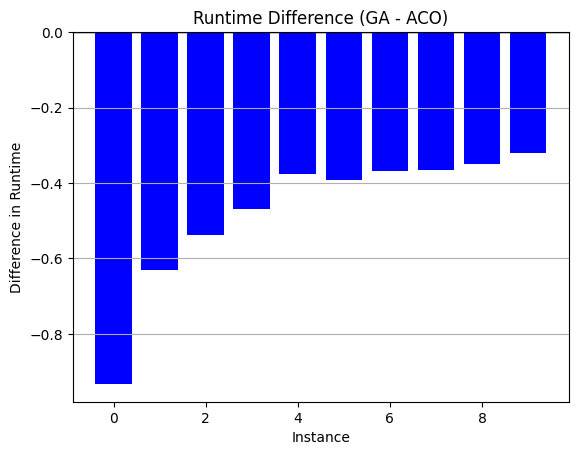

In [96]:
file_path = "/content/res_ga/small.txt"
sol_ga = process_file(file_path, "small")

file_path = "/content/res_aco/small.txt"
sol_aco = process_file(file_path, "small")

time_ga = np.array([result[4] for result in sol_ga])
time_aco = np.array([result[4] for result in sol_aco])

plot_time_comparison(time_ga, time_aco)

Instance: content/test/med/inst_200_20_00001 - Min Cost: 21993565.00 - Avg Cost: 22029296.00 - Std. Dev: 33541.40 - Time:12.112
Instance: content/test/med/inst_200_20_00002 - Min Cost: 7704776.00 - Avg Cost: 7747120.40 - Std. Dev: 25130.07 - Time:7.44
Instance: content/test/med/inst_200_20_00003 - Min Cost: 3898835.00 - Avg Cost: 3907547.80 - Std. Dev: 7123.79 - Time:5.408
Instance: content/test/med/inst_200_20_00004 - Min Cost: 2232350.00 - Avg Cost: 2242550.40 - Std. Dev: 8188.45 - Time:4.395999999999999
Instance: content/test/med/inst_200_20_00005 - Min Cost: 1402749.00 - Avg Cost: 1406925.40 - Std. Dev: 4482.49 - Time:3.696
Instance: content/test/med/inst_200_20_00006 - Min Cost: 1026378.00 - Avg Cost: 1035081.00 - Std. Dev: 5688.26 - Time:3.286
Instance: content/test/med/inst_200_20_00007 - Min Cost: 760471.00 - Avg Cost: 764310.20 - Std. Dev: 3395.72 - Time:2.946
Instance: content/test/med/inst_200_20_00008 - Min Cost: 578776.00 - Avg Cost: 584369.20 - Std. Dev: 3248.01 - Time:2.

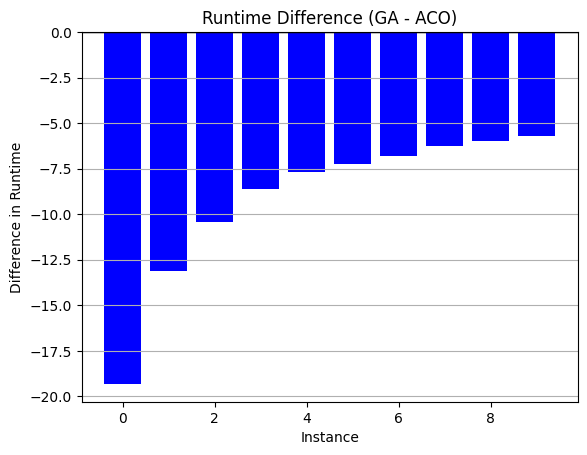

In [107]:
file_path = "/content/res_ga/medium.txt"
sol_ga = process_file(file_path, "medium")

file_path = "/content/res_aco/medium.txt"
sol_aco = process_file(file_path, "medium")

time_ga = np.array([result[4] for result in sol_ga])
time_aco = np.array([result[4] for result in sol_aco])

plot_time_comparison(time_ga, time_aco)

Instance: content/test/med_large/inst_500_40_00001 - Min Cost: 38071236.00 - Avg Cost: 38297539.60 - Std. Dev: 137107.80 - Time:24.224
Instance: content/test/med_large/inst_500_40_00004 - Min Cost: 88493670.00 - Avg Cost: 88734662.60 - Std. Dev: 226414.08 - Time:33.60000000000001
Instance: content/test/med_large/inst_500_40_00007 - Min Cost: 158395698.00 - Avg Cost: 158777172.40 - Std. Dev: 324726.40 - Time:43.3
Instance: content/test/med_large/inst_500_40_00010 - Min Cost: 236880558.00 - Avg Cost: 237583174.00 - Std. Dev: 402871.74 - Time:51.843999999999994
Instance: content/test/med_large/inst_500_40_00013 - Min Cost: 321715822.00 - Avg Cost: 321941965.20 - Std. Dev: 229663.23 - Time:60.160000000000004
Instance: content/test/med_large/inst_500_40_00016 - Min Cost: 420478963.00 - Avg Cost: 420995098.20 - Std. Dev: 460965.98 - Time:67.37
Instance: content/test/med_large/inst_500_40_00019 - Min Cost: 516534698.00 - Avg Cost: 516929247.60 - Std. Dev: 388049.22 - Time:77.32000000000001
In

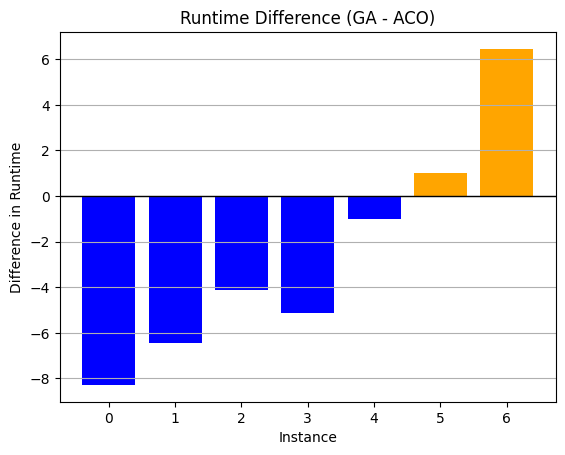

In [43]:
file_path = "/content/res_ga/medium_large.txt"
sol_ga = process_file(file_path, "medium_large")

file_path = "/content/res_aco/medium_large.txt"
sol_aco = process_file(file_path, "medium_large")

time_ga = np.array([result[4] for result in sol_ga])
time_aco = np.array([result[4] for result in sol_aco])

plot_time_comparison(time_ga, time_aco)

Instance: content/test/large/inst_1000_60_00001 - Min Cost: 14932274808.00 - Avg Cost: 14940999432.80 - Std. Dev: 7357125.34 - Time:476.726
Instance: content/test/large/inst_1000_60_00002 - Min Cost: 5237006884.00 - Avg Cost: 5240647169.60 - Std. Dev: 3089238.81 - Time:285.28
Instance: content/test/large/inst_1000_60_00003 - Min Cost: 2635439581.00 - Avg Cost: 2638299603.00 - Std. Dev: 2365392.52 - Time:208.702
Instance: content/test/large/inst_1000_60_00004 - Min Cost: 1567803702.00 - Avg Cost: 1570023131.40 - Std. Dev: 2031316.78 - Time:162.81
Instance: content/test/large/inst_1000_60_00005 - Min Cost: 1029816197.00 - Avg Cost: 1032566067.00 - Std. Dev: 1721904.19 - Time:136.07
Instance: content/test/large/inst_1000_60_00006 - Min Cost: 741743231.00 - Avg Cost: 743305842.60 - Std. Dev: 1086723.04 - Time:116.69800000000001
Instance: content/test/large/inst_1000_60_00007 - Min Cost: 543493785.00 - Avg Cost: 544783865.00 - Std. Dev: 1146068.40 - Time:102.9
Instance: content/test/large/i

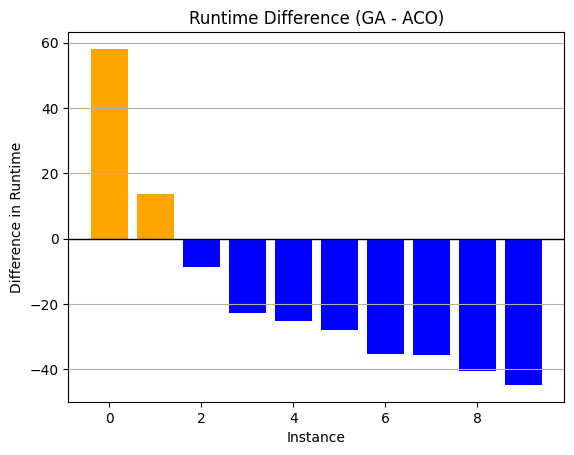

In [44]:
file_path = "/content/res_ga/large.txt"
sol_ga = process_file(file_path, "large")

file_path = "/content/res_aco/large.txt"
sol_aco = process_file(file_path, "large")

time_ga = np.array([result[4] for result in sol_ga])
time_aco = np.array([result[4] for result in sol_aco])

plot_time_comparison(time_ga, time_aco)

# Competition

In [48]:
items

['/content/competition/inst_50_4_00001',
 '/content/competition/inst_500_40_00003',
 '/content/competition/inst_500_40_00021',
 '/content/competition/inst_200_20_00001',
 '/content/competition/inst_500_40_00012']

In [54]:
params = GAParameters(population_size=40, generations=300, elite_size=13, tournament_size=25, mutation_rate=0.255, crossover_rate=0.79, constraint_penalty=213178)


for item in items:
    graph = load_instance(item)

    # Solve the problem
    solution, cost = solve_mwccp(graph, params)
    print(f"Minimum weighted crossing cost: {cost}")
    instance_name = os.path.basename(item)
    with open(f"{instance_name}_ga.txt", "w") as f:
        f.write(instance_name + "\n")
        f.write(" ".join(map(str, solution)) + "\n")


Generation 1/300
Generation 2/300
Generation 3/300
Generation 4/300
Generation 5/300
Generation 6/300
Generation 7/300
Generation 8/300
Generation 9/300
Generation 10/300
Generation 11/300
Generation 12/300
Generation 13/300
Generation 14/300
Generation 15/300
Generation 16/300
Generation 17/300
Generation 18/300
Generation 19/300
Generation 20/300
Generation 21/300
Generation 22/300
Generation 23/300
Generation 24/300
Generation 25/300
Generation 26/300
Generation 27/300
Generation 28/300
Generation 29/300
Generation 30/300
Generation 31/300
Generation 32/300
Generation 33/300
Generation 34/300
Generation 35/300
Generation 36/300
Generation 37/300
Generation 38/300
Generation 39/300
Generation 40/300
Generation 41/300
Generation 42/300
Generation 43/300
Generation 44/300
Generation 45/300
Generation 46/300
Generation 47/300
Generation 48/300
Generation 49/300
Generation 50/300
Generation 51/300
Generation 52/300
Generation 53/300
Generation 54/300
Generation 55/300
Generation 56/300
G

KeyboardInterrupt: 

In [55]:
for item in items:
    graph = load_instance(item)
    aco = MaxMinAntSystem(graph, alpha=1.87, beta=1.07, evaporation_rate=0.69, ant_count=22, iterations=150, tau_min = 0.51, tau_max = 7.85)

    # Solve the problem
    solution, cost = aco.ant_colony_optimization()
    print(f"Minimum weighted crossing cost: {cost}")
    instance_name = os.path.basename(item)
    with open(f"{instance_name}_aco.txt", "w") as f:
        f.write(instance_name + "\n")
        f.write(" ".join(map(str, solution)) + "\n")

Minimum weighted crossing cost: 76811.0
Minimum weighted crossing cost: 69303447.0
Minimum weighted crossing cost: 586875484.0
Minimum weighted crossing cost: 21680886.0


KeyboardInterrupt: 